**Estimating Coritsol Levels in Ringed Seals in the Canadian Arctic**

*By: Laura Raposo*

*Class: GDAA 2010*

Data used for this project was obtained from Canada Open Data and was submited by:    

*Wesley R Ogloff, Randi A Anderson, David J Yurkowski, Cassandra D Debets, W Gary Anderson, Steven H Ferguson. 2022 Spatiotemporal variation of ringed seal blubber cortisol levels in the Canadian Arctic. Arctic and Aquatic Research Division, Fisheries and Oceans Canada, Winnipeg, MB. https://open.canada.ca/data/en/dataset/e1c6b350-0159-11ed-8212-1860247f53e3*

The dataset contains cortisol levels derived from blubber samples taken from ringed seal in the Canadian Arctic spanning the years 2002 to 2012, this is the target variable. In addition to cortisol levels, biological metrics including length, weight, and body condition (measured by blubber depth) were recorded, alongside dietary indicators such as δ13C, δ15N, and isotopic niche size. These parameters serve as the predictors for this analysis.

Species in the Arctic ecosystem have faced significant challenges due to climate change, marked by reductions in sea ice cover, alterations in prey availability, heightened exposure to contaminants, and increased industrial shipping causing noise pollution. Such changes have greatly effected species like the ringed seal, whose life cycles are linked to the presence of sea ice. Consequently, these environmental stressors can cause chronic stress among ringed seals.

This project aims to predict the relationship between demographic factors, dietary patterns, and chronic stress by predicting cortisol levels. 

**Import and Basic Cleaning**

Irrelevant columns were removed and cortisol was moved to the first place

In [ ]:
import pandas as pd

file_path = "Ringed_Seal_Blubber_Cortisol_Levels_in_the_Canadian_Arctic.csv"
df = pd.read_csv(file_path, encoding='latin1')

columns_to_remove = [0,1,2,3,4,5,6,7,8,9,10,11,12]
df_cleaned = df.drop(df.columns[columns_to_remove], axis=1)

column_4 = df_cleaned.pop('Cortisol  (ng/g)')  # Remove column 'D'
df_cleaned.insert(0, 'Cortisol  (ng/g)', column_4)  # Insert column 'D' at position 0

print(df_cleaned.columns)
print(df.columns)


**Impute Missing Data**

This data inclued various NA values across all variables, removing rows with any NA values greatly reduced the size of the dataset and therefore it was decided to impute the missing values with an interative imputer. 

*The iterative imputer* was chosen becuase it provides more accurate imputations compared to simpler methods like mean or median imputation, especially when the relationships between features is complex and the dataset has missing values in multiple columns, which this one does. This method uses a machine learning model with the missing values being treated as the target variable and the non-missing values in the row as the predictors. Using this imputer we were able to maintain the size of the dataset 

Histograms of all varaibles were made as an initial inspection of data shape

Index(['Cortisol  (ng/g)', 'Length', 'Axillary Girth', 'Hip Girth',
       'SternumDepth', 'Weight (kg)', 'Sculp Weight (kg) ', 'd13C', 'd15N',
       'CN / C-N'],
      dtype='object')


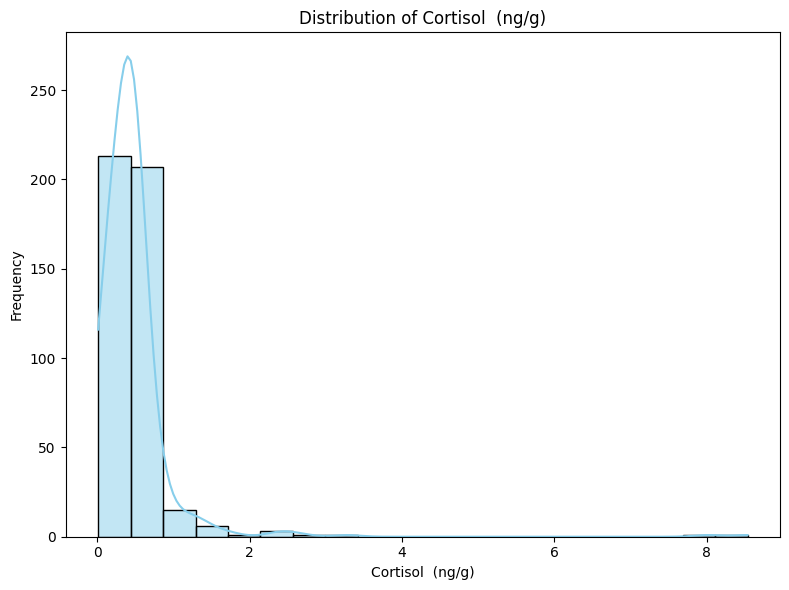

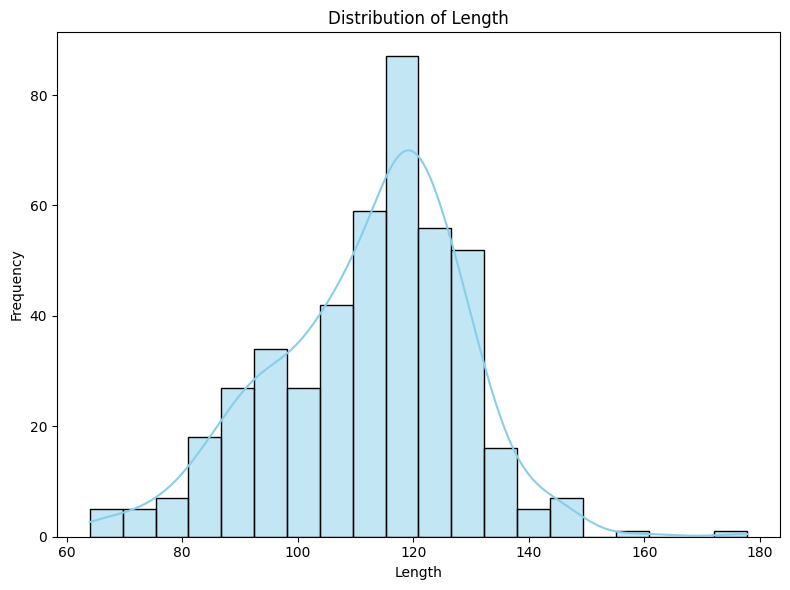

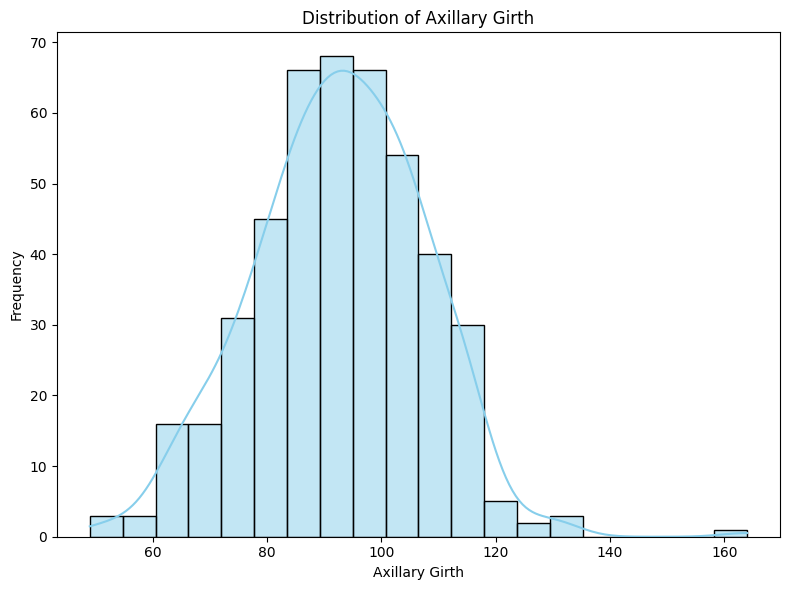

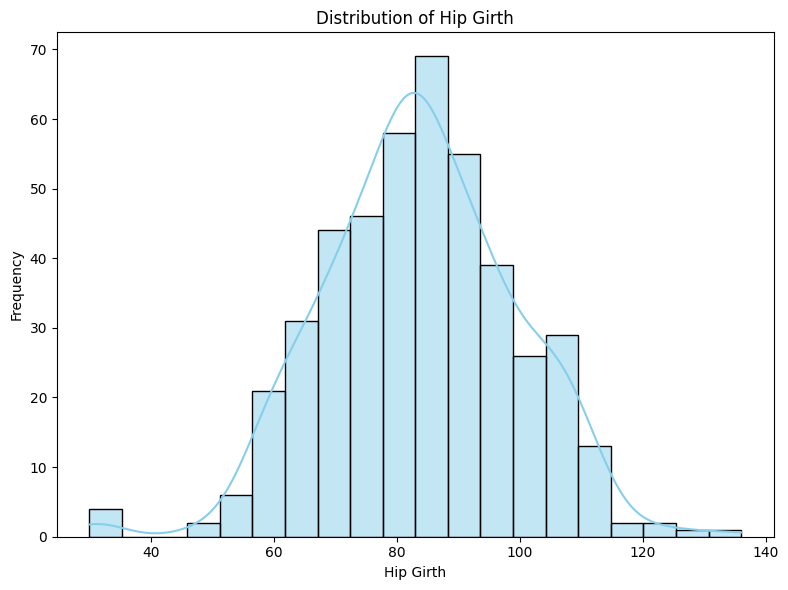

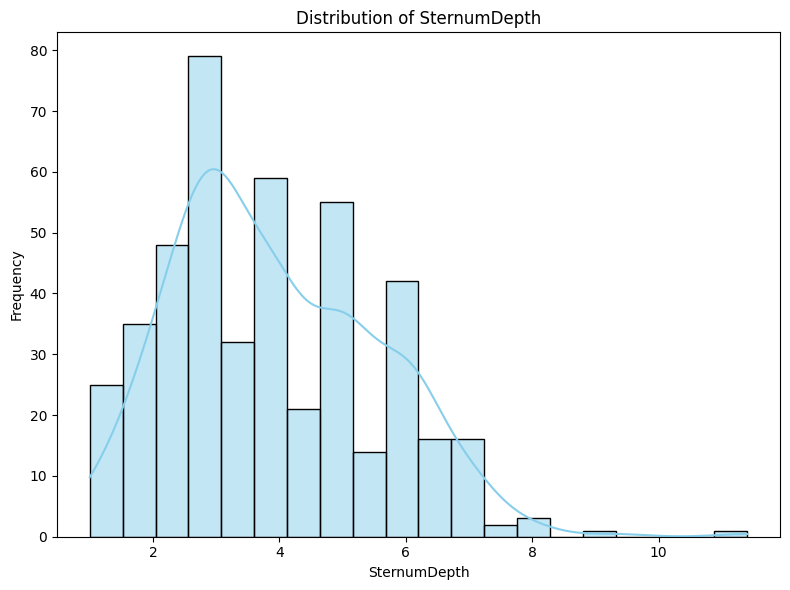

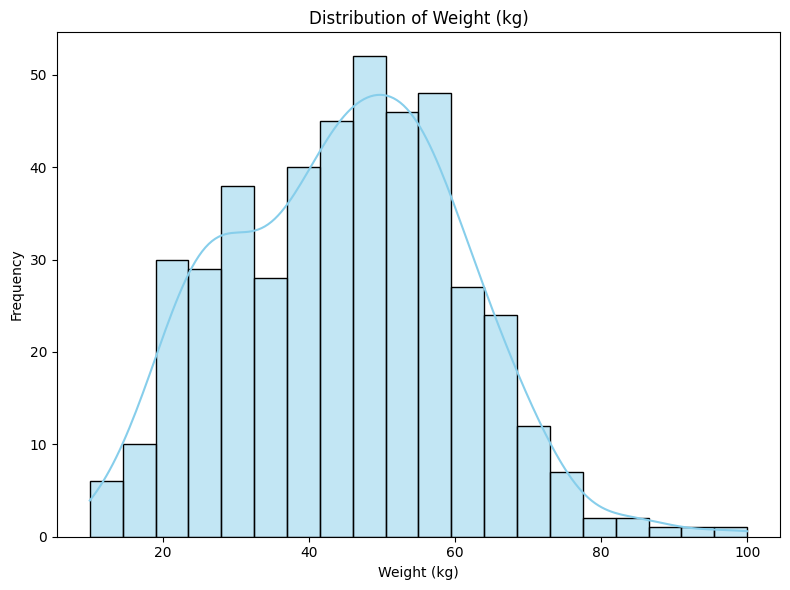

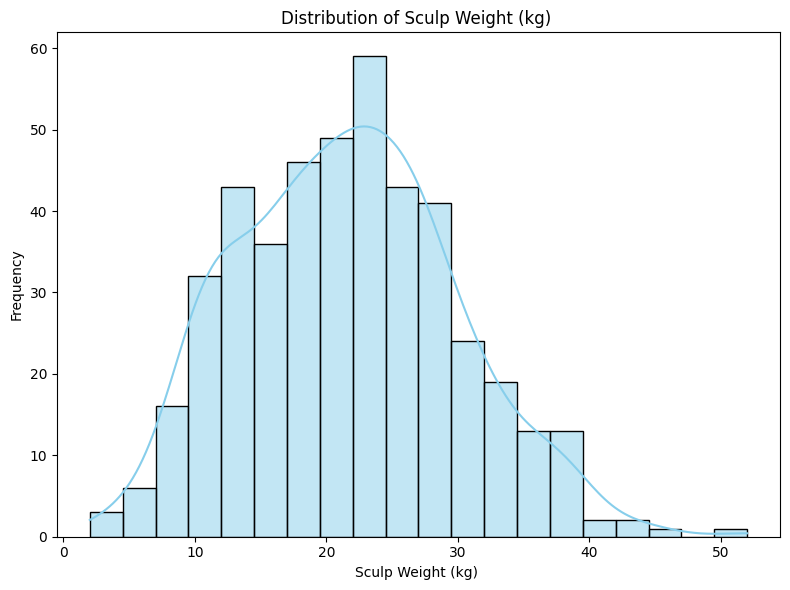

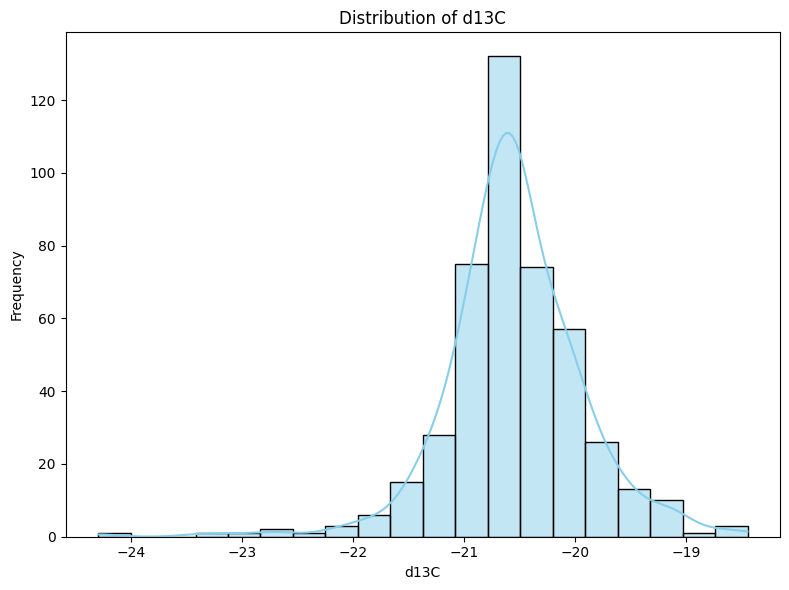

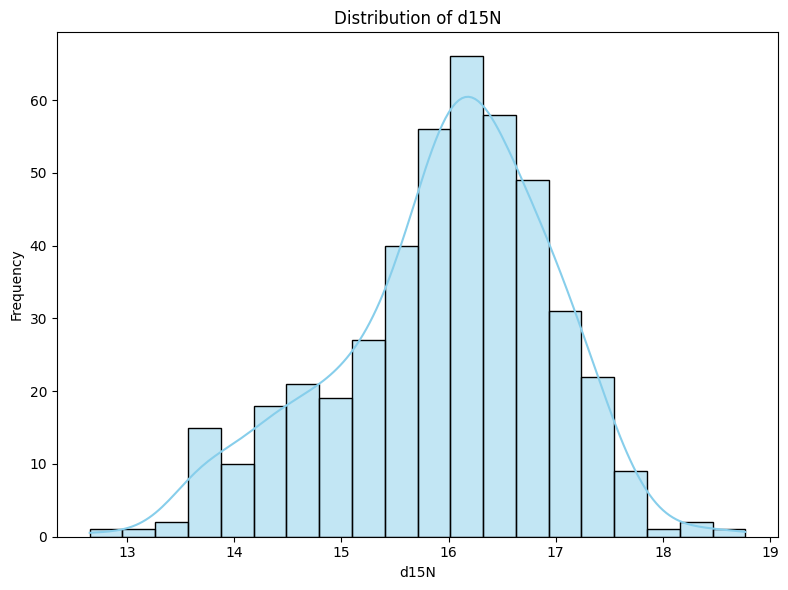

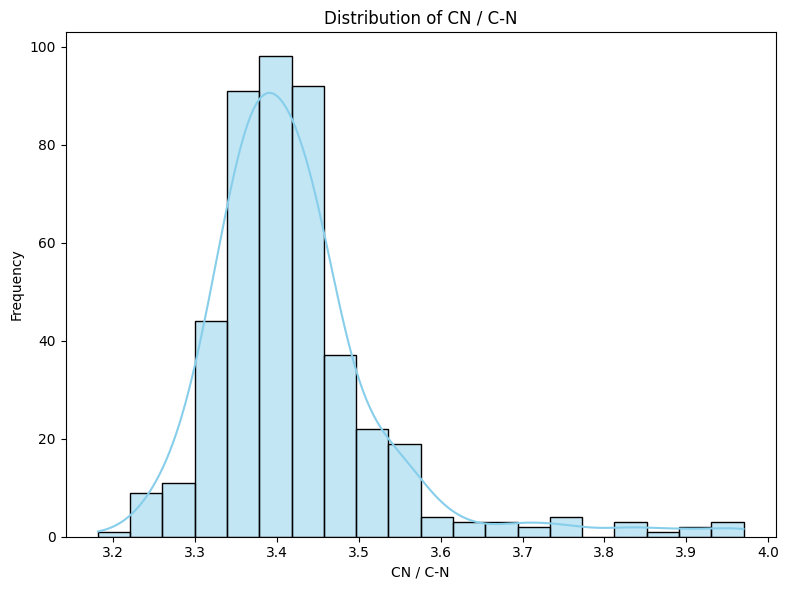

In [9]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Impute missing values with Iterative imputer for all columns
imputer = IterativeImputer(max_iter=200, random_state=2010) 
df_imputed = pd.DataFrame(imputer.fit_transform(df_cleaned), columns=df_cleaned.columns)

# Display the DataFrame after imputation
print(df_imputed.columns)

# Define the list of variables from df_imputed
variables = df_imputed.columns

# Loop through each variable and create a histogram
for variable in variables:
    plt.figure(figsize=(8, 6))
    sns.histplot(df_imputed[variable], kde=True, color='skyblue', bins=20) 
    plt.title(f"Distribution of {variable}") 
    plt.xlabel(variable)  
    plt.ylabel("Frequency") 
    plt.tight_layout()  
    plt.show()  




**Trimming Outliers and Scaling Data**

The predictors were initially scaled using a standard scaler and then trimmed using a percentile scale, where the lower limit was set to 10 and the upper limit was set to 90. These specific percentile values were chosen after testing various combinations and determining that they resulted in the lowest RMSE values when evaluated with a simple default linear model. 

Following this preprocessing, histograms were created to visually assess the distribution of the data. Upon examination, it was observed that outliers still persisted, particularly for 'Hip Girth'. To address this, manual outlier removal was performed. For 'Hip Girth', outliers with values less than 40 were removed. 'Length' and 'Sculp Weight (kg)' values less than or equal to 3 where also removed.

Additionally for the target variable, 'Cortisol (ng/g)', outliers exceeding a value of two were eliminated. This manual intervention aimed to enhance the robustness of the dataset and improve the accuracy of subsequent analyses as the model would not have been as acturate at predicting cortisol at the very high levels as there were very few data points. 

This process reduced our dataset from 345 to 346. This dataframe was then reindexed to correct any changes in the index after trimming.

Dimensions of the DataFrame: (445, 10)
Dimensions of the DataFrame: (347, 10)


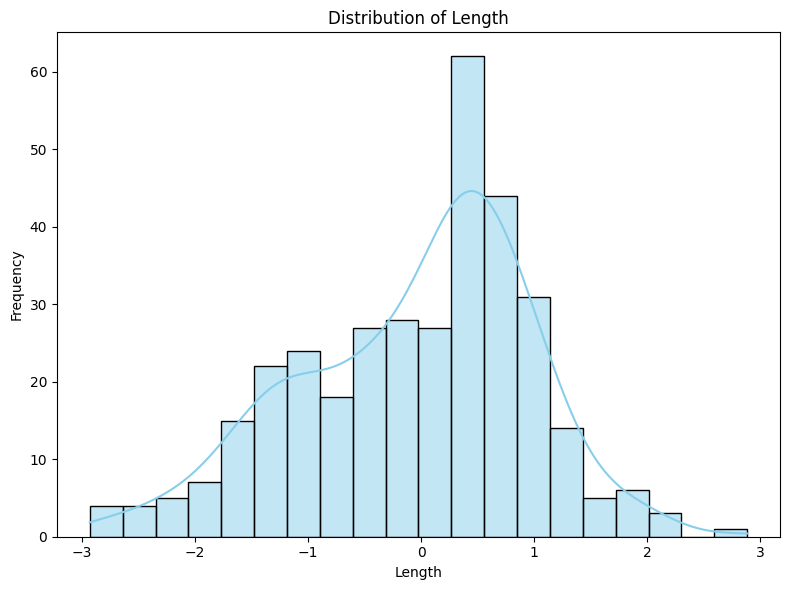

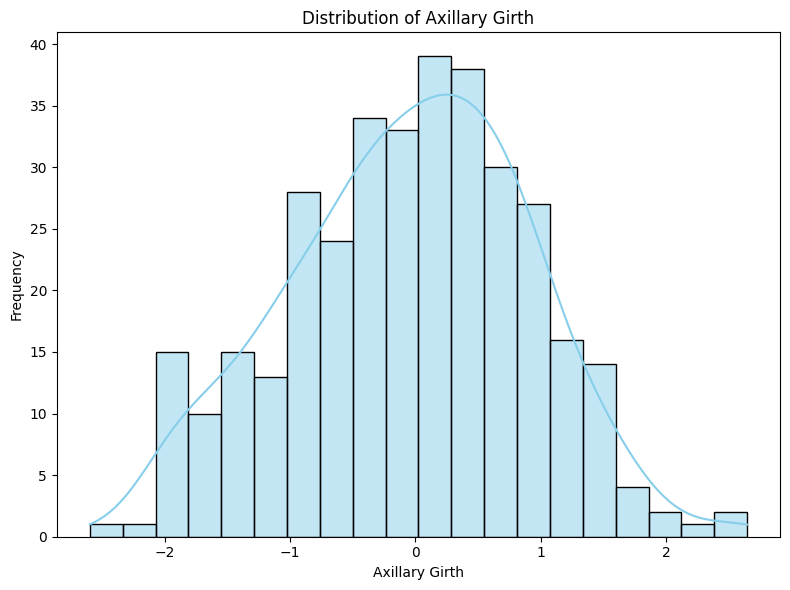

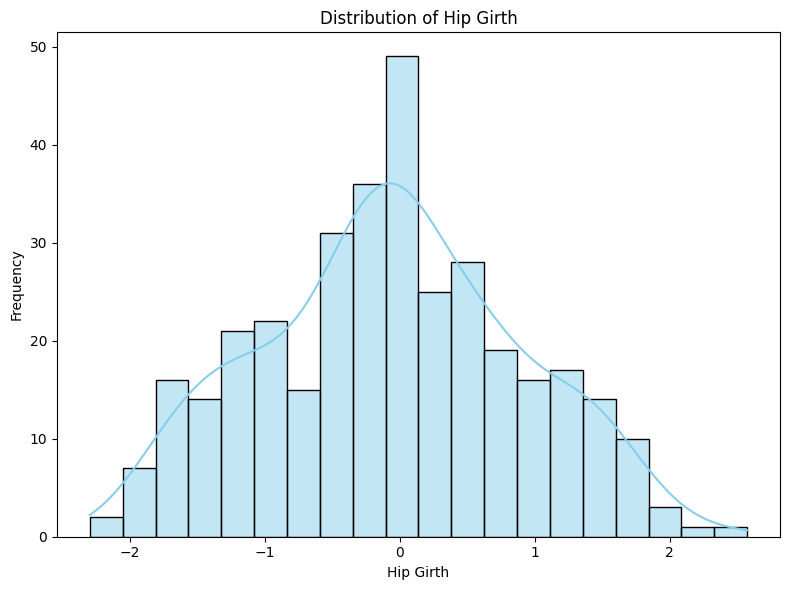

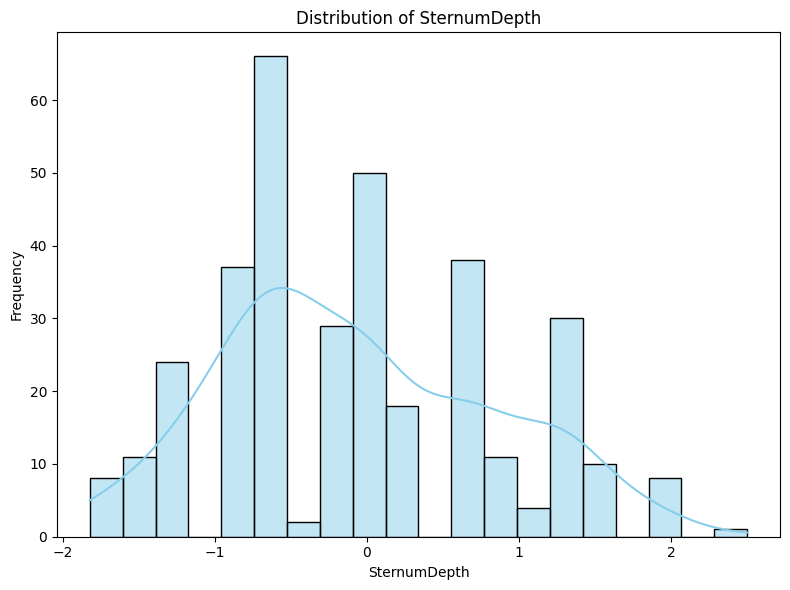

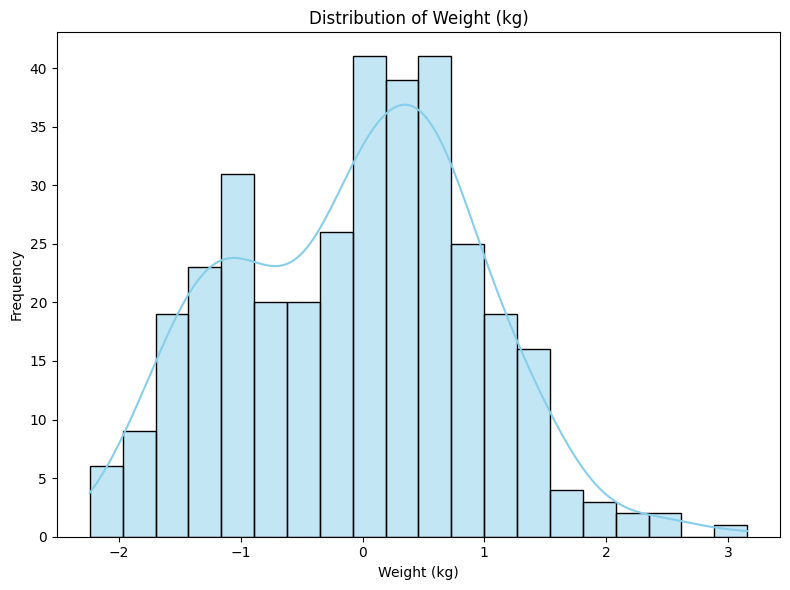

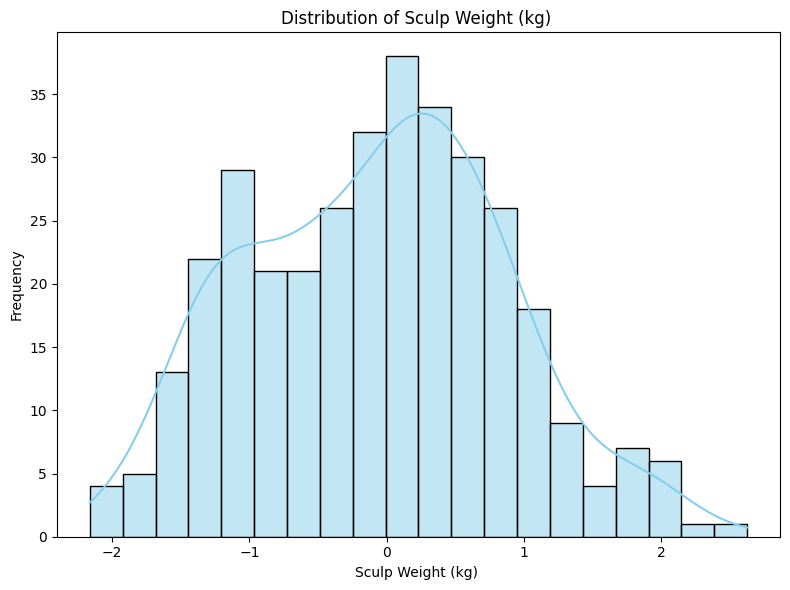

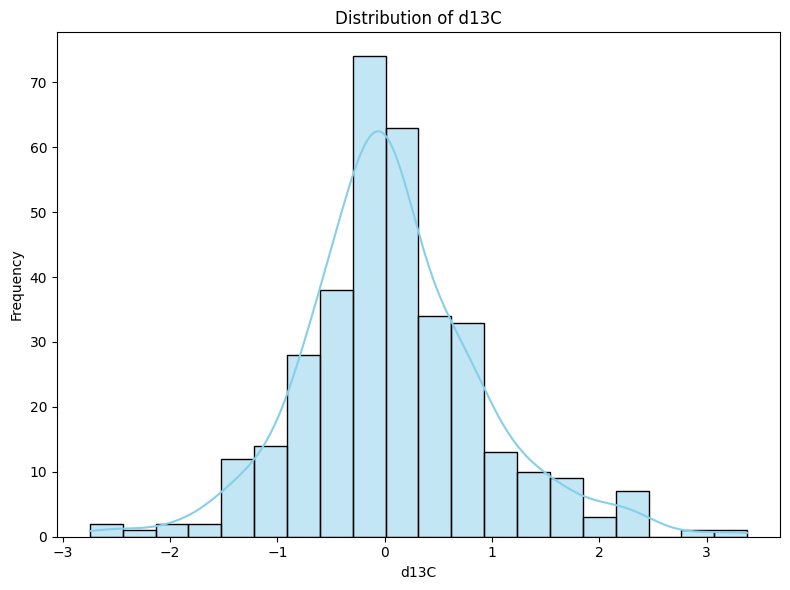

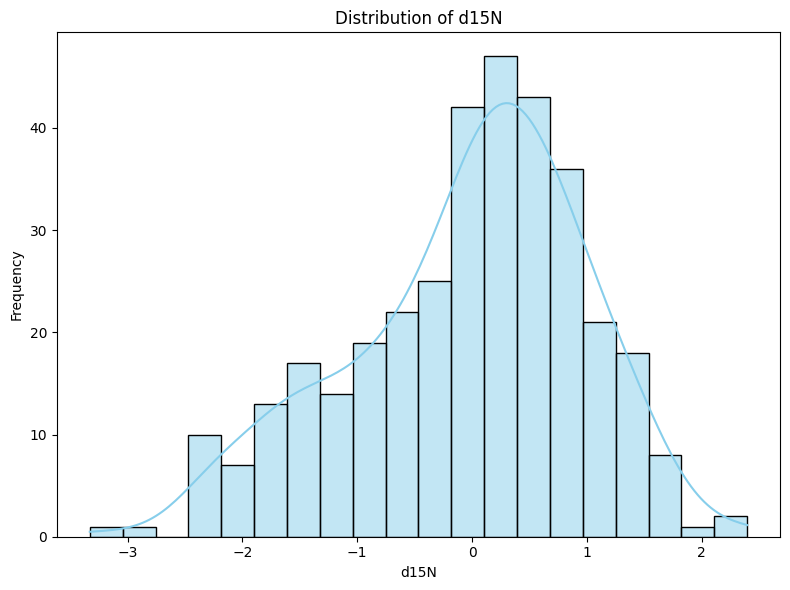

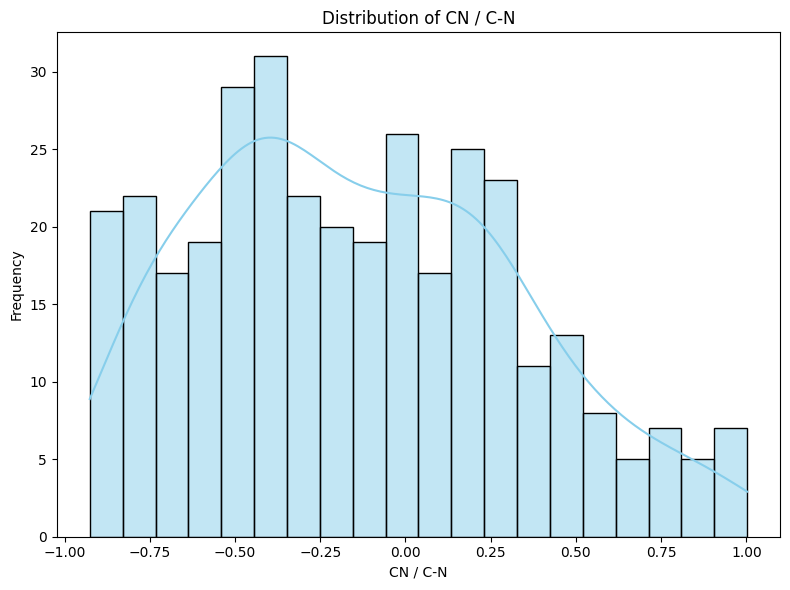

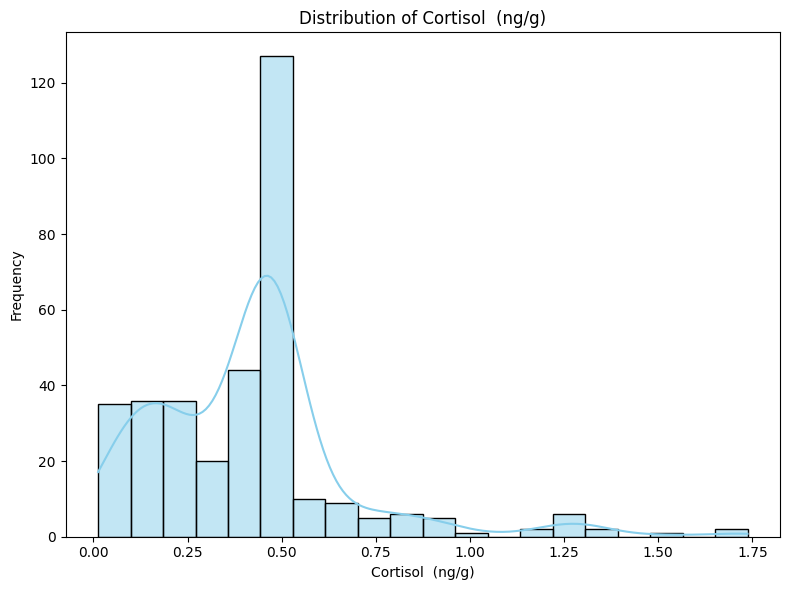

In [10]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

# Manually Remove outliers for 'Hip Girth' column 
df_imputed = df_imputed[df_imputed['Hip Girth'] >= 40]

# Separate the target variable and predictors
target = df_imputed['Cortisol  (ng/g)']
predictors = df_imputed.drop(columns=['Cortisol  (ng/g)'])

# Scale the predictors
scaler = StandardScaler()
scaled_predictors = scaler.fit_transform(predictors)

# Convert the scaled predictors back to a DataFrame
df_scaled = pd.DataFrame(scaled_predictors, columns=predictors.columns)

# Concatenate the scaled predictors with the target variable
df_scaled['Cortisol  (ng/g)'] = target

print("Dimensions of the DataFrame:", df_scaled.shape)

# Specify the percentiles for trimming outliers
lower_percentile = 10
upper_percentile = 90

# Calculate the lower and upper percentile values for each predictor
lower_percentile_values = df_scaled.iloc[:, :-1].apply(lambda x: np.percentile(x.dropna(), lower_percentile))
upper_percentile_values = df_scaled.iloc[:, :-1].apply(lambda x: np.percentile(x.dropna(), upper_percentile))

# Identify rows containing outliers and drop them entirely from the dataset
trimmed_scaled_df_z_percentile = df_scaled.copy()
for col in lower_percentile_values.index:
    is_outlier_lower = trimmed_scaled_df_z_percentile[col] < lower_percentile_values[col]
    is_outlier_upper = trimmed_scaled_df_z_percentile[col] > upper_percentile_values[col]
    outliers_index = is_outlier_lower | is_outlier_upper
    df_trimmed_scaled = trimmed_scaled_df_z_percentile[~outliers_index]

#Manually trim outliers that persisted 
df_trimmed_scaled = df_trimmed_scaled[df_trimmed_scaled['Cortisol  (ng/g)'] <= 2]
df_trimmed_scaled = df_trimmed_scaled[df_trimmed_scaled['Length'] <= 3]
df_trimmed_scaled = df_trimmed_scaled[df_trimmed_scaled['Sculp Weight (kg) '] <= 3]

# Reindex 
df_trimmed_scaled=df_trimmed_scaled.reset_index(drop=True)

print("Dimensions of the DataFrame:", df_trimmed_scaled.shape)

#Display Histograms for Trimmed and Scalled
variables = df_trimmed_scaled

for variable in variables:
    plt.figure(figsize=(8, 6))
    sns.histplot(df_trimmed_scaled[variable], kde=True, color='skyblue', bins=20) 
    plt.title(f"Distribution of {variable}") 
    plt.xlabel(variable)  
    plt.ylabel("Frequency") 
    plt.tight_layout()  
    plt.show()  



**Exploratory Data Analysis**

*A Shapiro-Wilks Test* was used to assess how normally distributed the variable are.Variables with p-values less than 0.05 are considered to be significantly different from a normal distribution. The results revealed that all variables exhibited significant deviations from normality. Specifically, Sternum Depth, d13C, d15N, CN / C-N had extremely small p-values, suggesting strong evidence against normality. While Hip Girth and Weight (kg) had slightly higher p-values, they still fell below the significance threshold, indicating departures from normality. Becuase all variables were bellow 0.05 a transformation will be applied to them in the next section of code

*Multicollinearity* occurs when two or more independent variables in a regression model are highly correlated with each other. A correlation matrix was used to assess multicollinearity with the variables. Variables with a high correlation coefficients (close to 1 or -1) with each other may indicate multicollinearity. Generally, correlation coefficients above 0.7 or below -0.7 are considered to indicate strong multicollinearity.'Axillary Girth' and 'Hip Girth' have a correlation coefficient of approximately 0.91, indicating a positive correlation. Additionally,'Weight (kg)' and 'Sculp Weight (kg)' have a correlation coefficient of approximately 0.94, also indicating a positive correlation.

Some of the other variables that show some correlation are between 'Auxillary Girth' and ' Sculp Weight (kg)' (0.844), and also between 'Length' and 'Weight' (0.851).

These high correlations suggest multicollinearity between these pairs of variables. To mitigate multicollinearity, one of the variables can be removed from each highly correlated pair, or techniques like principal component analysis (PCA) can be used to reduce dimensionality while preserving most of the variance in the data. For the purposes of this project PCA will be run on the data instead of removing the variables as it will reduce multicollinearity in the regression model without the loss of information. In this project interpertability is not extremely important and therefore PCA offers more benefits than removing the variables. 

Variables with absolute correlation coefficient > 0.7:
1. Weight (kg) - Sculp Weight (kg) : 0.9363993513218941
2. Axillary Girth - Hip Girth: 0.9081332030830888
3. Length - Weight (kg): 0.8516514937332008
4. Axillary Girth - Sculp Weight (kg) : 0.8447069000023817
5. Hip Girth - Sculp Weight (kg) : 0.8246206205454567
6. Axillary Girth - Weight (kg): 0.7927936329719701
7. Length - Sculp Weight (kg) : 0.780042280067531
8. Hip Girth - Weight (kg): 0.7577334264479388

Variables most correlated with 'Cortisol (ng/g)':
1. SternumDepth          0.120350
2. d15N                  0.069149
3. Hip Girth             0.029788
4. Weight (kg)           0.025118
5. CN / C-N              0.024123
6. Sculp Weight (kg)     0.012276
7. Length                0.011770
8. Axillary Girth        0.004505
9. d13C                  0.000118

           Length  Axillary Girth   Hip Girth  SternumDepth  Weight (kg)  \
count  347.000000      347.000000  347.000000    347.000000   347.000000   
mean    -0.053781       -0.051020   -0.062703     -0.070045    -0.057808   
std      1.019992        0.951484    0.957251      0.897462     0.996987   
min     -2.928998       -2.598294   -2.298047     -1.821852    -2.239634   
25%     -0.777774       -0.702863   -0.687197     -0.586610    -0.901848   
50%      0.193395        0.003730   -0.075877     -0.216037     0.052254   
75%      0.612984        0.658690    0.584379      0.648632     0.633207   
max      2.883485        2.647098    2.573176      2.501495     3.158114   

       Sculp Weight (kg)         d13C        d15N    CN / C-N  \
count          347.000000  347.000000  347.000000  347.000000   
mean            -0.071183    0.074887   -0.040037   -0.140647   
std              0.936311    0.847350    1.020555    0.463727   
min             -2.162643   -2.746955   -3.329402   -0.

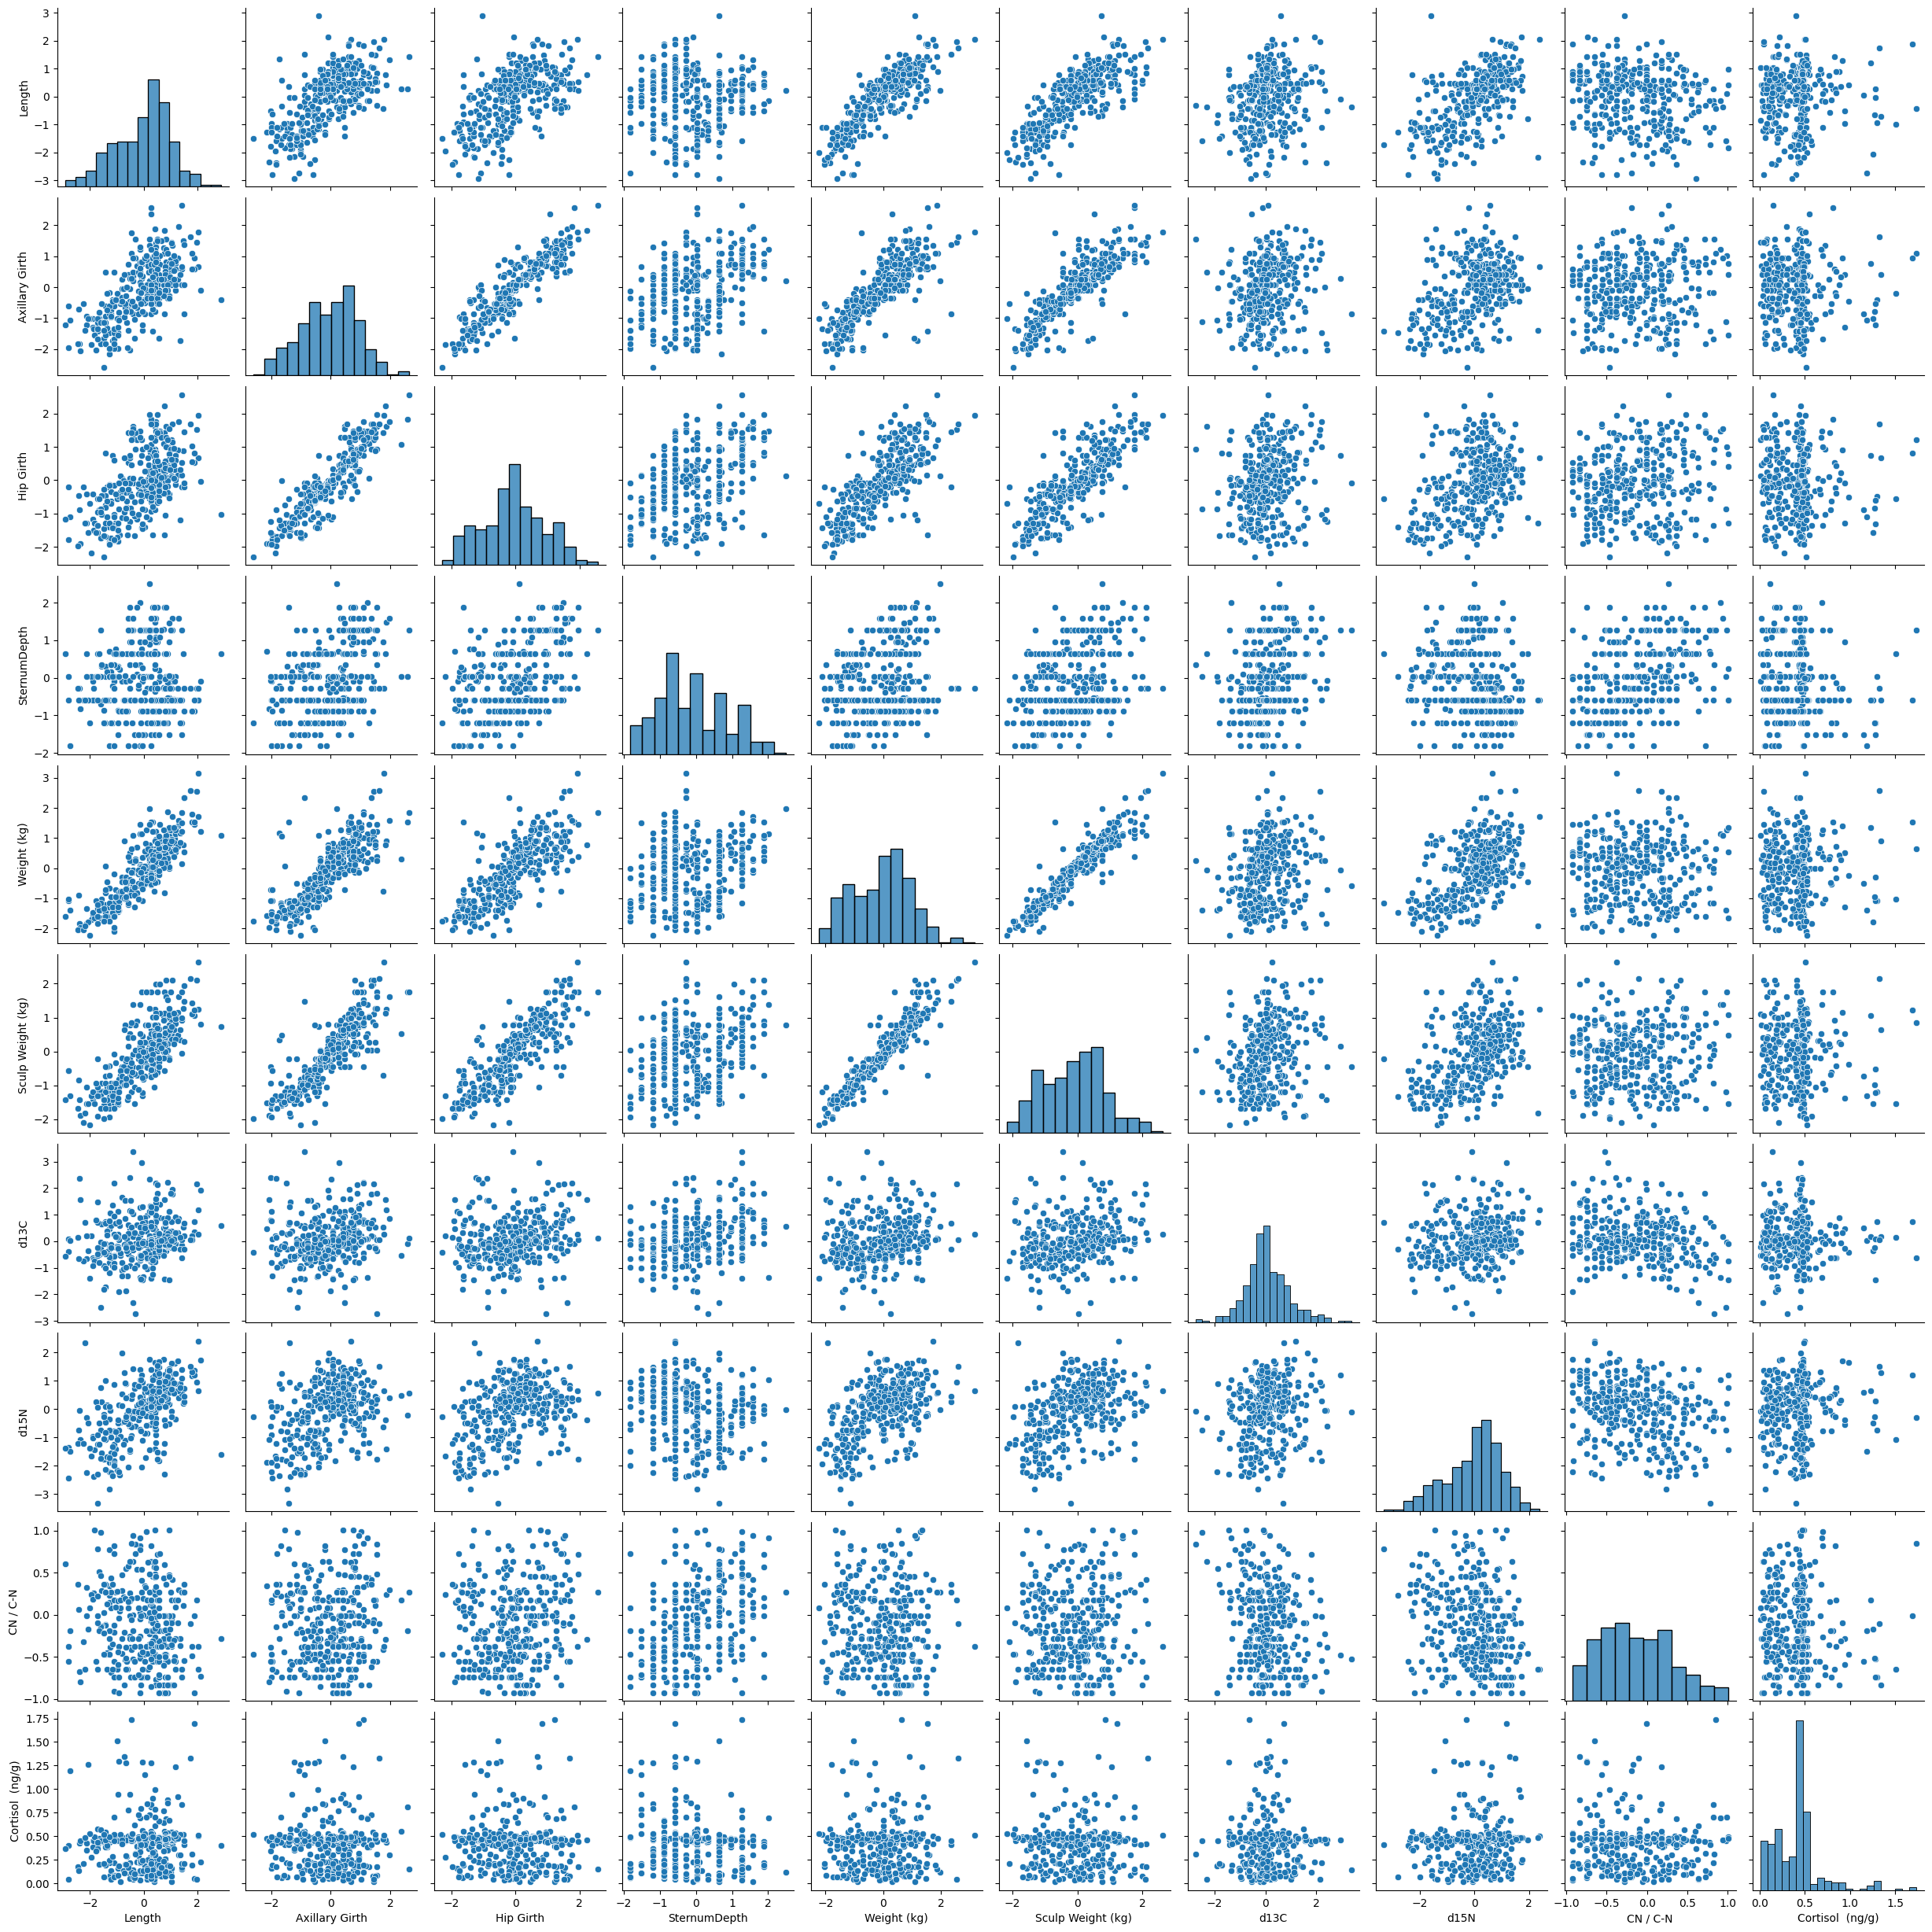

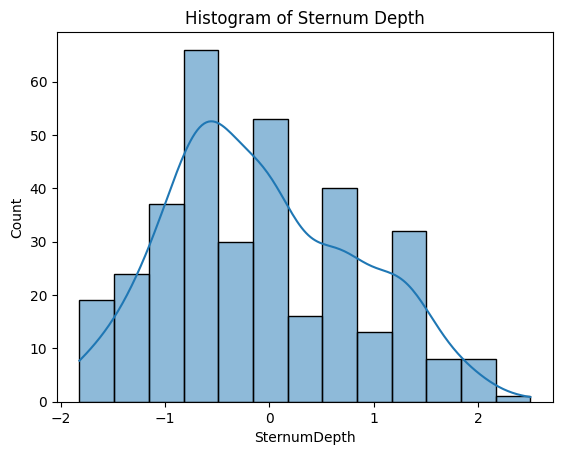

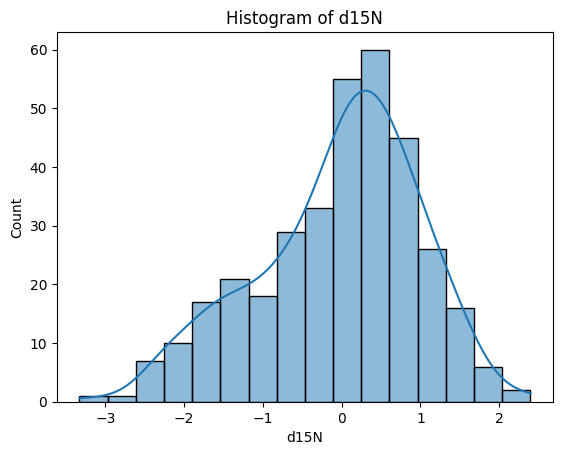

In [11]:
from scipy.stats import shapiro 
import seaborn as sns

# Compute summary statistics and correlation coefficients
summary_statistics = df_trimmed_scaled.describe()
correlation_matrix = df_trimmed_scaled.corr()
print(summary_statistics)
print(correlation_matrix)

# Which variables are most correlated with Cotrisol 
correlation_with_cortisol = correlation_matrix['Cortisol  (ng/g)'] 
correlation_with_cortisol.drop('Cortisol  (ng/g)', inplace=True)  

abs_correlation_with_cortisol = correlation_with_cortisol.abs()
sorted_correlation = abs_correlation_with_cortisol.sort_values(ascending=False)
print("Variables most correlated with 'Cortisol (ng/g)':")
print(sorted_correlation)


# Which varaibles have an absolute correlation coefficant > 0.7
threshold = 0.7  
correlated_variables = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        var1 = correlation_matrix.columns[i]
        var2 = correlation_matrix.columns[j]
        correlation = correlation_matrix.iloc[i, j]
        if abs(correlation) > threshold:
            correlated_variables.append((var1, var2, correlation))
correlated_variables_sorted = sorted(correlated_variables, key=lambda x: abs(x[2]), reverse=True)
print("Variables showing moderate correlation (absolute correlation coefficient > 0.7):")
for var1, var2, correlation in correlated_variables_sorted:
    print(f"{var1} - {var2}: {correlation}")


# Loop through each variable and perform Shapiro-Wilk test
for variable in df_trimmed_scaled.columns:
    stat, p = shapiro(df_trimmed_scaled[variable])
    print(f"Shapiro-Wilk test for {variable} - p-value:", p)


sns.pairplot(df_trimmed_scaled)
plt.show()

# Plot histograms of the two predictors with the highest correlation coefficients to the target variable
sns.histplot(df_trimmed_scaled['SternumDepth'], kde=True)
plt.title("Histogram of Sternum Depth")
plt.show()

sns.histplot(df_trimmed_scaled['d15N'], kde=True)
plt.title("Histogram of d15N")
plt.show()



**Apply Transformation to Non-Normally Distributed Data**

The next step aims improve the normality of data through transformations. Logarithmic transformation is applied to positively skewed variables like 'Weight (kg)' and 'CN / C-N', while Box-Cox transformation is used for negatively skewed variables such as 'Hip Girth', 'd13C', and 'd15N'. The transformation process involves adjusting the data to approximate a more normal distribution. After trial and error different scaling factores were used for some varaibles such as weight, and CN/C-N.

No transformations were made on Sternum Depth as various attempts where made and no method improved the distribution, becuase of this it was decided that sternum depth be removed from transformations.

Following the transformation, histograms are plotted to visualize the original imputed data, scaled and trimmed data, and transformed distributions for each variable. 

Additionally, the Shapiro-Wilk test is conducted again on each transformed variable to assess if normality improved after transformation. The Shapiro-Wilk test results reveal whether the transformed data deviate significantly from a normal distribution, although did show some improvements. Larger p-values were seen in 'Weight (Kg)' , 'CN / C-N', 'Hip Girth', 'd15N' and 'd13C'.  These variables demonstrated slight improvement in their distributions towards normality after transformation, although are still not normally distributed, this will have to be taken into account during model selection

     SternumDepth  Cortisol  (ng/g)  Weight (kg)  CN / C-N  \
0        1.266253          0.271275     0.052838  0.055646   
1       -0.086337          0.449492    -0.170404  0.118150   
2       -0.086337          0.013084     0.102516 -0.028758   
3       -0.086337          0.488656     0.014924  0.083126   
4        0.648632          0.460072     0.095548 -0.317172   
..            ...               ...          ...       ...   
342     -0.586610          0.131430    -0.094900  0.028468   
343     -1.204231          1.277604    -0.101237 -0.299107   
344     -0.895420          0.388522    -0.009503 -0.289273   
345     -0.586610          0.169681     0.016579 -0.208793   
346     -0.586610          0.072292     0.085715 -0.198022   

     Sculp Weight (kg)   Hip Girth      d13C      d15N  Axillary Girth  
0              0.070530   2.759275  3.110190  4.953539        3.860437  
1             -0.151537   1.053573  1.769976  3.991734        1.350475  
2              0.104310   3.055164  

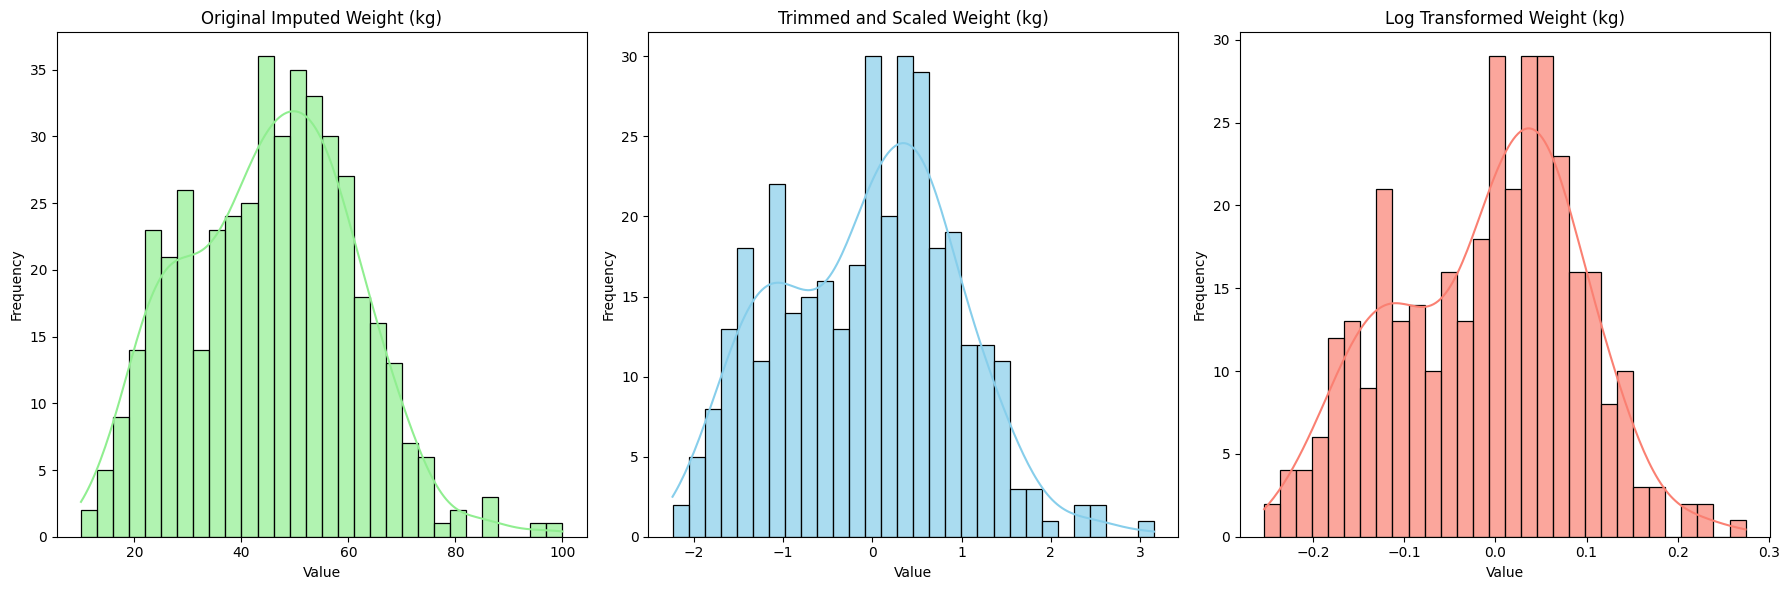

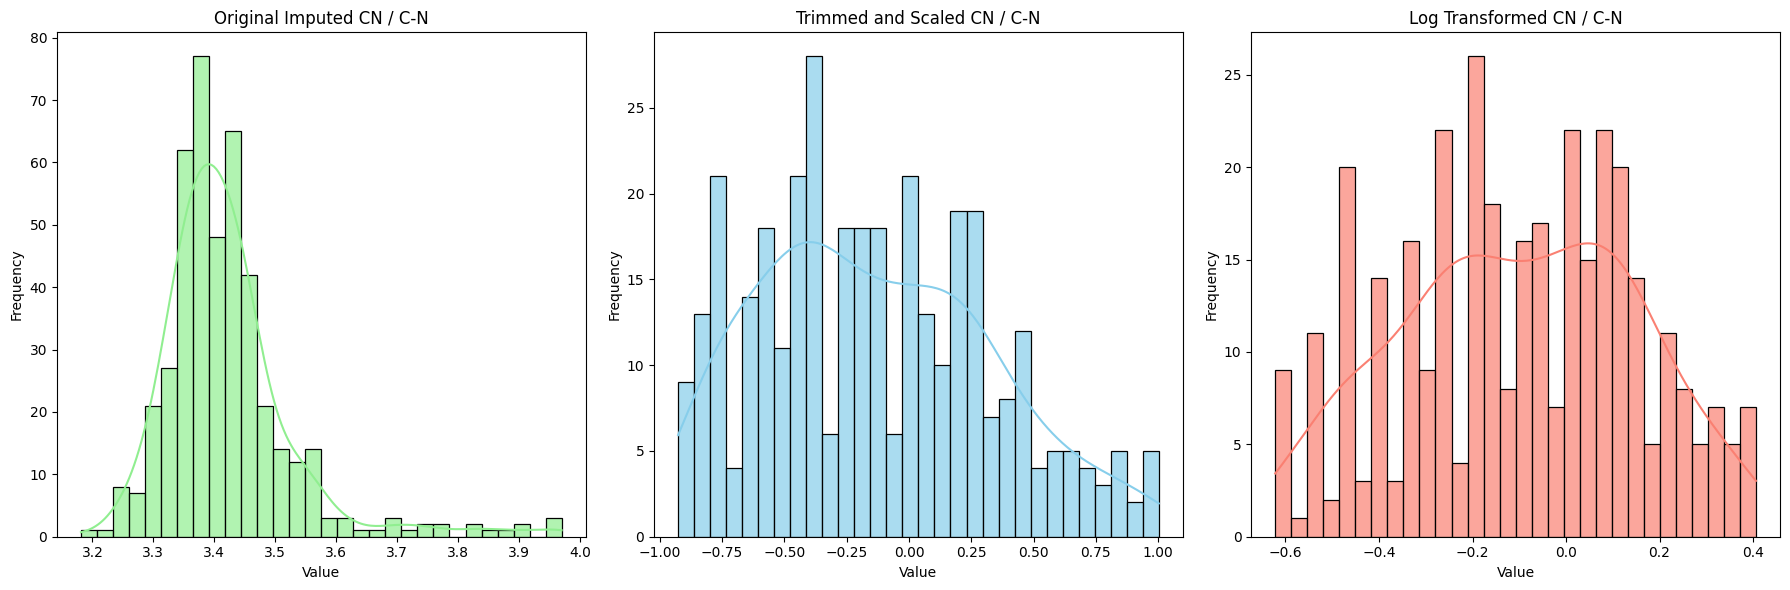

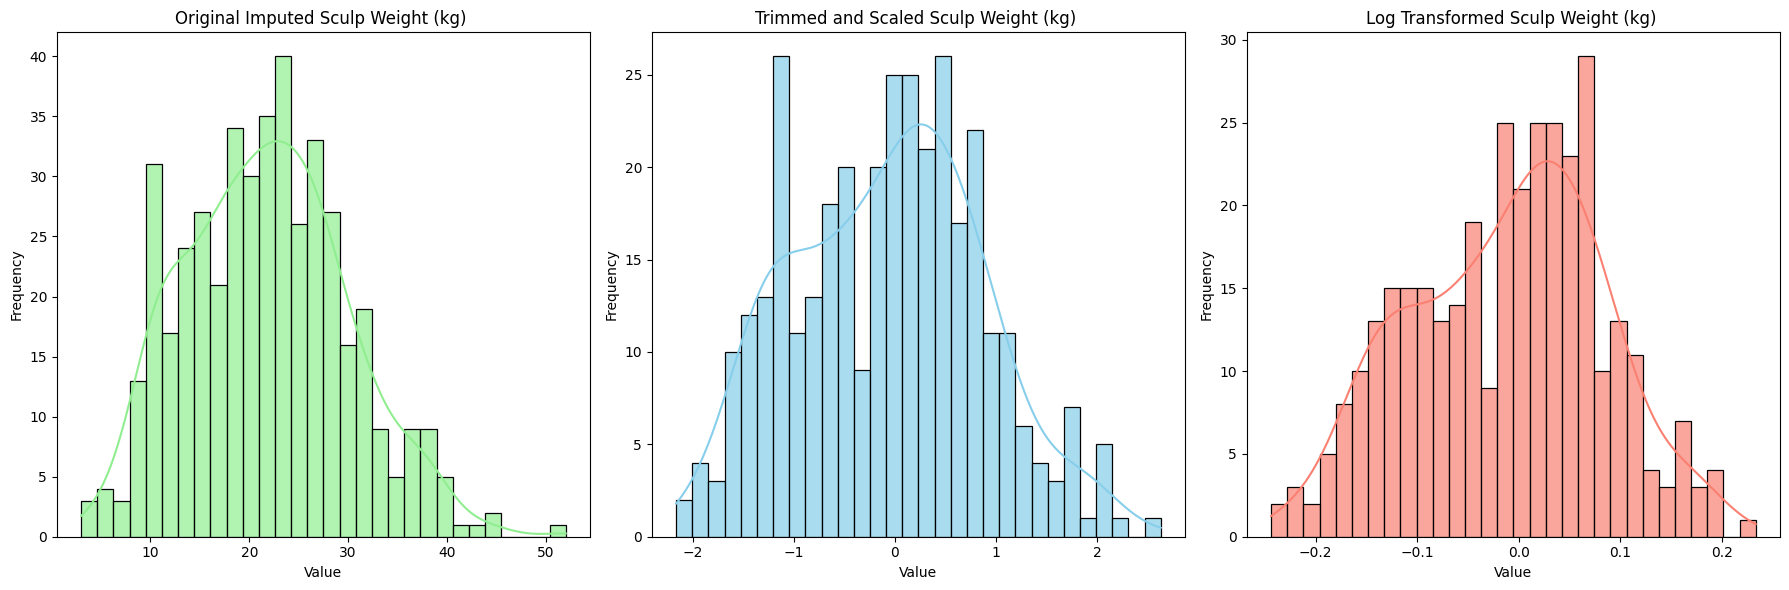

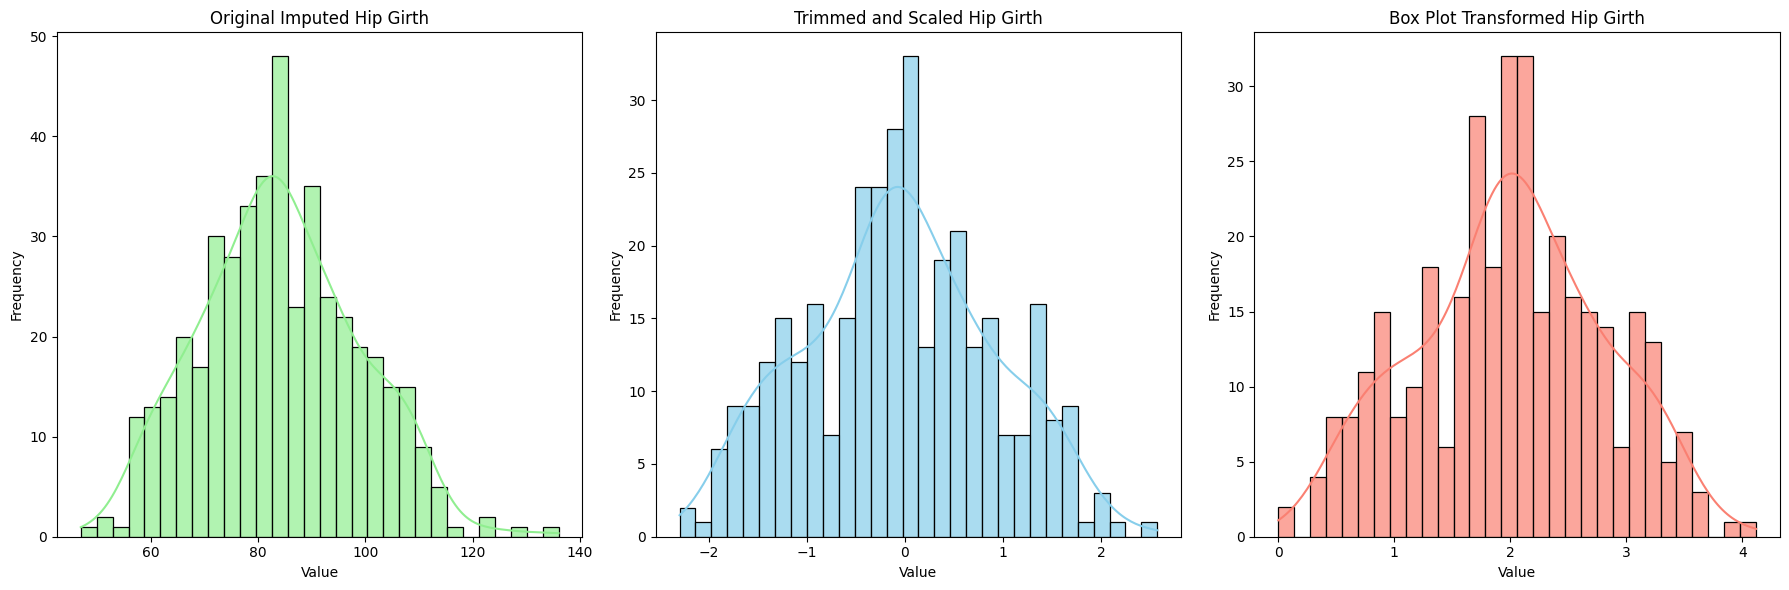

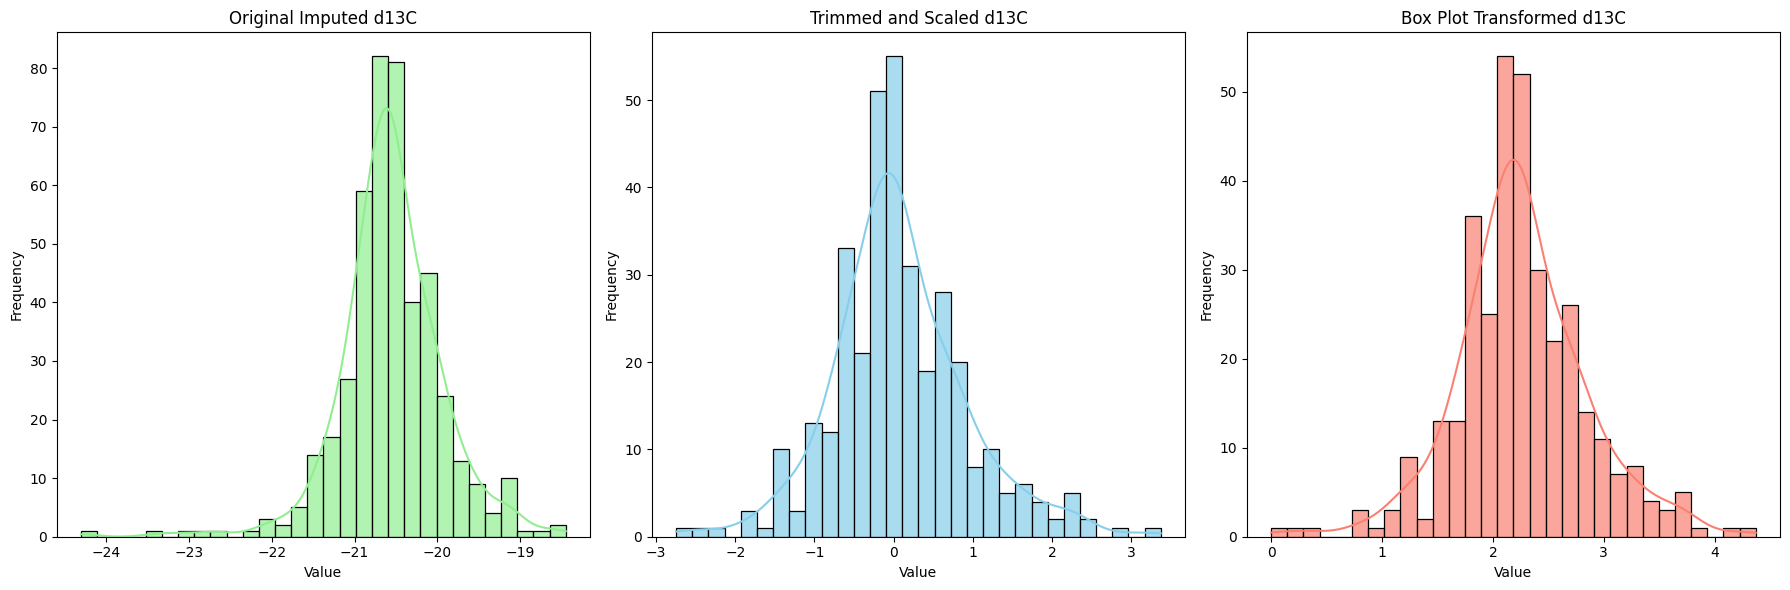

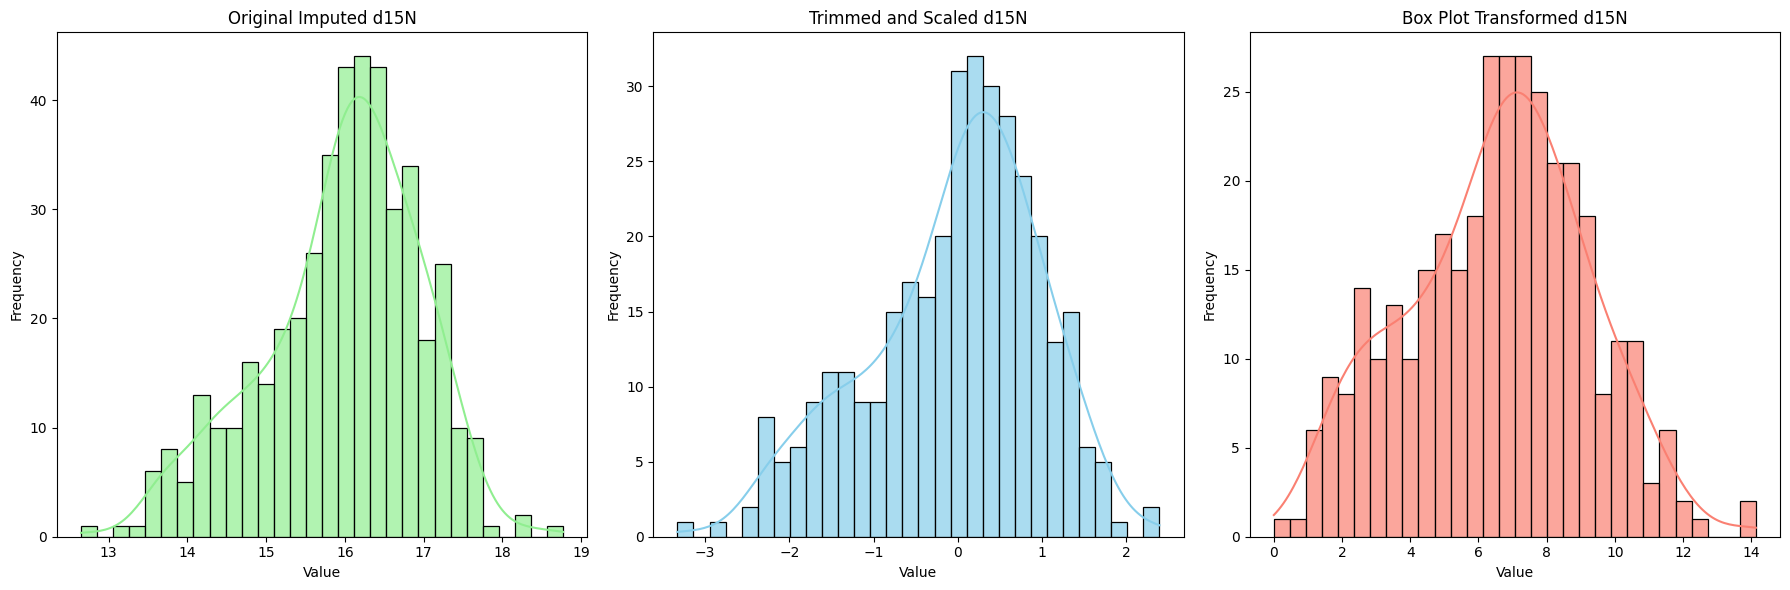

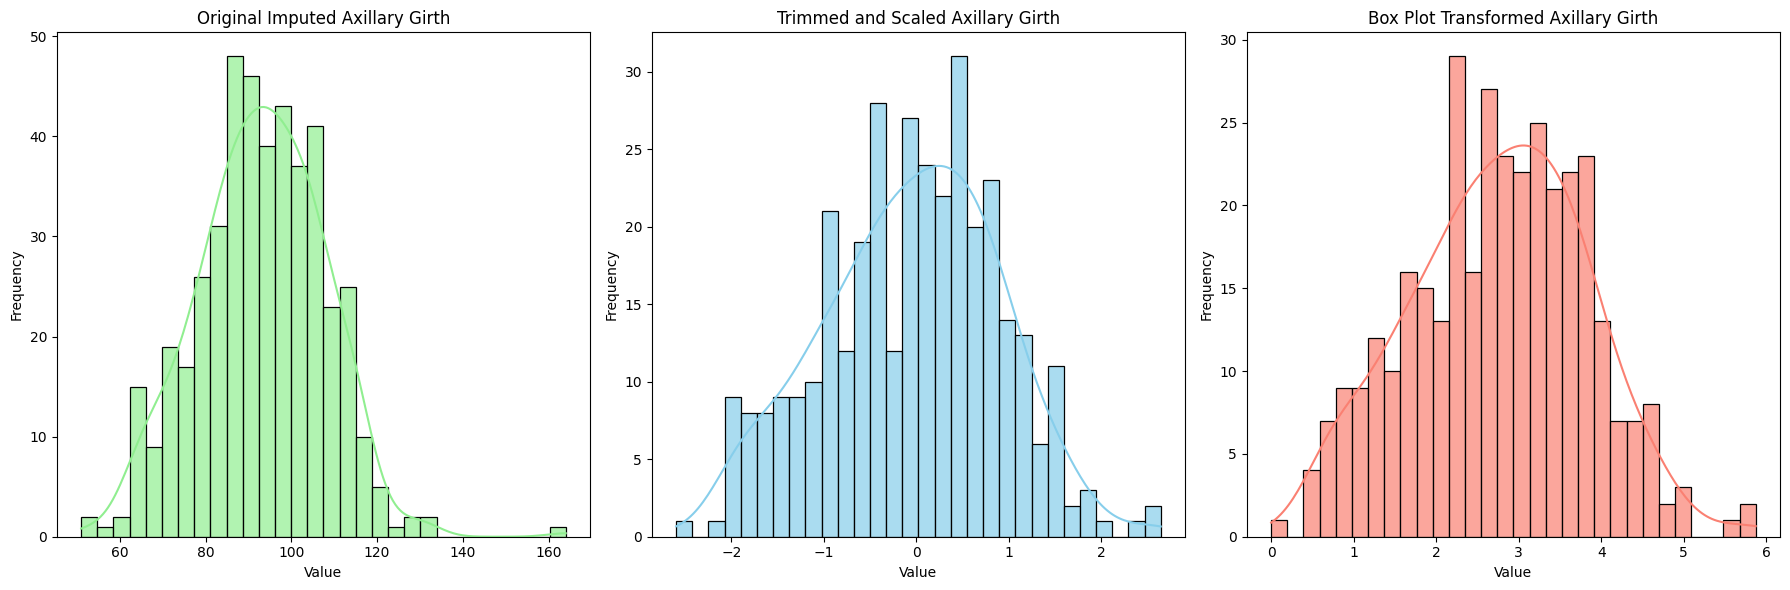

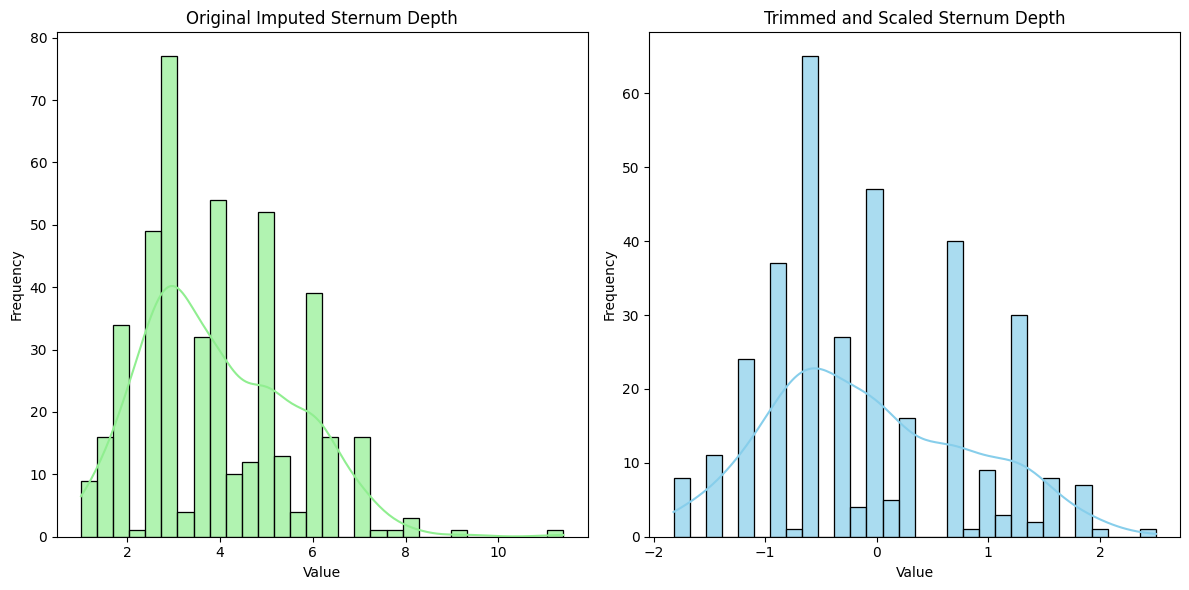

Lambda (λ) parameter for Box-Cox transformation:
Hip Girth: 1.0947615052425275
d13C: 1.0947615052425275
d15N: 1.0947615052425275
Axillary Girth: 1.0947615052425275
Shapiro-Wilk test for SternumDepth - p-value: 6.016179554535483e-07
Shapiro-Wilk test for Cortisol  (ng/g) - p-value: 5.864985994144946e-18
Shapiro-Wilk test for Weight (kg) - p-value: 0.00028529134579002857
Shapiro-Wilk test for CN / C-N - p-value: 0.0002161363954655826
Shapiro-Wilk test for Sculp Weight (kg)  - p-value: 0.00632744375616312
Shapiro-Wilk test for Hip Girth - p-value: 0.026299042627215385
Shapiro-Wilk test for d13C - p-value: 2.1257559637888335e-05
Shapiro-Wilk test for d15N - p-value: 0.016081323847174644
Shapiro-Wilk test for Axillary Girth - p-value: 0.1192990094423294
Missing values in each column:
SternumDepth          0
Cortisol  (ng/g)      0
Weight (kg)           0
CN / C-N              0
Sculp Weight (kg)     0
Hip Girth             0
d13C                  0
d15N                  0
Axillary Girth    

In [12]:
from scipy.stats import shapiro
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import boxcox
import seaborn as sns

# Initialize a new DataFrame to store transformed values
df_transformed = df_trimmed_scaled[['SternumDepth','Cortisol  (ng/g)']].copy()

# Define Positively and Negatively Skewed Data:
positively_skewed_variables = ['Weight (kg)', 'CN / C-N', 'Sculp Weight (kg) ']
negatively_skewed_variables = ['Hip Girth', 'd13C', 'd15N', 'Axillary Girth']

# Log transformation for Positively skewed data
scaling_factors = {'Weight (kg)': 0.1, 'CN / C-N': 0.5,'Sculp Weight (kg) ' :0.1 }

# Apply logarithmic transformation to the positively skewed variable
for variable in positively_skewed_variables:
    scaling_factor = scaling_factors.get(variable)  
    df_transformed[f'{variable}'] = np.log(df_trimmed_scaled[variable] * scaling_factor + 1)  

# Box-Cox transformation for negatively skewed data
for variable in negatively_skewed_variables:
    # Add a constant value to make the data positive
    constant_shift = np.abs(df_trimmed_scaled[variable].min()) + 1
    neg_skewed_data_shifted = df_trimmed_scaled[variable] + constant_shift
    
    # Apply Box-Cox transformation
    transformed_data, lambda_boxcox = boxcox(neg_skewed_data_shifted)
    
    # Store transformed data in df_transformed
    df_transformed[f'{variable}'] = transformed_data

print (df_transformed)

# Plotting the original imputed, scaled and trimmed, and transformed distributions for positively skewed data
for variable in positively_skewed_variables:
    plt.figure(figsize=(18, 6))
    
    # Imputed positively skewed variable
    plt.subplot(1, 3, 1)
    sns.histplot(df_imputed[variable], bins=30, color='lightgreen', edgecolor='black', alpha=0.7, kde=True)
    plt.title(f'Original Imputed {variable}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    # Original positively skewed variable
    plt.subplot(1, 3, 2)
    sns.histplot(df_trimmed_scaled[variable], bins=30, color='skyblue', edgecolor='black', alpha=0.7, kde=True)
    plt.title(f'Trimmed and Scaled {variable}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    # Transformed positively skewed variable
    plt.subplot(1, 3, 3)
    sns.histplot(df_transformed[variable], bins=30, color='salmon', edgecolor='black', alpha=0.7, kde=True)
    plt.title(f'Log Transformed {variable}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Plotting the original imputed, scaled and trimmed, and transformed distributions for negatively skewed data
for variable in negatively_skewed_variables:
    plt.figure(figsize=(18, 6))
    
    # Imputed negatively skewed variable
    plt.subplot(1, 3, 1)
    sns.histplot(df_imputed[variable], bins=30, color='lightgreen', edgecolor='black', alpha=0.7, kde=True)
    plt.title(f'Original Imputed {variable}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    # Original negatively skewed variable
    plt.subplot(1, 3, 2)
    sns.histplot(df_trimmed_scaled[variable], bins=30, color='skyblue', edgecolor='black', alpha=0.7, kde=True)
    plt.title(f'Trimmed and Scaled {variable}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    # Transformed negatively skewed variable
    plt.subplot(1, 3, 3)
    sns.histplot(df_transformed[variable], bins=30, color='salmon', edgecolor='black', alpha=0.7, kde=True)
    plt.title(f'Box Plot Transformed {variable}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Plotting the imputed and original distributions for SternumDepth which wasn't transformed
plt.figure(figsize=(12, 6))

# Imputed SternumDepth
plt.subplot(1, 2, 1)
sns.histplot(df_imputed['SternumDepth'], bins=30, color='lightgreen', edgecolor='black', alpha=0.7, kde=True)
plt.title('Original Imputed Sternum Depth')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Original SternumDepth
plt.subplot(1, 2, 2)
sns.histplot(df_trimmed_scaled['SternumDepth'], bins=30, color='skyblue', edgecolor='black', alpha=0.7, kde=True)
plt.title('Trimmed and Scaled Sternum Depth')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Displaying lambda values for Box-Cox transformation
print("Lambda (λ) parameter for Box-Cox transformation:")
for variable in negatively_skewed_variables:
    print(f"{variable}: {lambda_boxcox}")


# Loop through each variable and perform Shapiro-Wilk test
for variable in df_transformed.columns:
    stat, p = shapiro(df_transformed[variable])
    print(f"Shapiro-Wilk test for {variable} - p-value:", p)


# Assuming df is your DataFrame
# Check for missing values in the entire DataFrame
missing_values = df_transformed.isna().sum()

# Alternatively, you can use isnull()
# missing_values = df.isnull().sum()

# Print the count of missing values for each column
print("Missing values in each column:")
print(missing_values)

# Check if there are any missing values in the DataFrame
if missing_values.sum() == 0:
    print("No missing values found in the DataFrame.")
else:
    print("There are missing values in the DataFrame.")


**Data Augmentation**

*Data Augmentation* enhances the dataset by artificially increasing its size through various transformations, thereby providing more diverse samples for model training. As the data doesn't show a clear linear relationship between the target varaible and predictors a second degree polynomial augmentation was used. The decision to use a second-degree polynomial augmentation is made to allow for capturing more complex relationships beyond linear effects. This augmentation enriches the dataset with higher-order interactions, enabling machine learning models to better approximate the underlying data distribution and potentially improve the predictive performance. 

In [13]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import pandas as pd

# Define the polynomial features transformer with degree=3
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)

# Select the predictor variables
predictors = df_transformed.drop(columns=['Cortisol  (ng/g)'])

# Fit and transform the predictors to create polynomial features
X_poly = poly.fit_transform(predictors)

# Generate the new feature names
feature_names = poly.get_feature_names_out(predictors.columns)

# Create a DataFrame from the polynomial features
X_poly_df = pd.DataFrame(X_poly, columns=feature_names)

# Concatenate the original target column with the new polynomial features DataFrame
df_augmented = pd.concat([X_poly_df, df_transformed[['Cortisol  (ng/g)']]], axis=1)

# Print dimensions of the new DataFrame
print("Dimensions of the new DataFrame:", df_augmented.shape)

# Rescale Augmented data
scaler = StandardScaler()
features = df_augmented.drop(columns=['Cortisol  (ng/g)'])
scaled_features = scaler.fit_transform(features)

# Create a DataFrame for the scaled features
df_augmented_scaled = pd.DataFrame(scaled_features, columns=features.columns)

# Add the target variable 'Cortisol  (ng/g)' back to the scaled DataFrame
df_augmented_scaled = pd.concat([df_augmented[['Cortisol  (ng/g)']].reset_index(drop=True), df_augmented_scaled], axis=1)

# Print dimensions of the scaled DataFrame
print("Dimensions of the scaled DataFrame:", df_augmented_scaled.shape)
print(df_augmented_scaled)


Dimensions of the new DataFrame: (347, 45)
Dimensions of the scaled DataFrame: (347, 45)
     Cortisol  (ng/g)  SternumDepth  Weight (kg)  CN / C-N  \
0            0.271275      1.491125     0.630884  0.635364   
1            0.449492     -0.018179    -1.580137  0.883816   
2            0.013084     -0.018179     1.122908  0.299859   
3            0.488656     -0.018179     0.255377  0.744597   
4            0.460072      0.801945     1.053896 -0.846575   
..                ...           ...          ...       ...   
342          0.131430     -0.576414    -0.832331  0.527330   
343          1.277604     -1.265594    -0.895100 -0.774766   
344          0.388522     -0.921004     0.013453 -0.735679   
345          0.169681     -0.576414     0.271769 -0.415774   
346          0.072292     -0.576414     0.956504 -0.372959   

     Sculp Weight (kg)   Hip Girth      d13C      d15N  Axillary Girth  \
0              0.868719   0.946901  1.446000 -0.599389        1.037383   
1             -1.4

**PCA**

Because there was some multicollinearity seen in this dataset it was decided to run PCA to help mitigate multicollinearity issues by transforming correlated features into a new set of  uncorrelated features called principal components. Using data augmentation and PCA together on the same dataset can offer benefits for optimizing regression models. By combining data augmentation and PCA, regression model optimization can benefit from both the augmented dataset's enhanced diversity and the reduced dimensionality provided by PCA


   Cortisol  (ng/g)      pca_0      pca_1
0          0.271275 -23.057508  17.047607
1          0.449492 -38.969225  -9.070966
2          0.013084  -6.856484  17.732716
3          0.488656 -48.795013   0.586116
4          0.460072  37.536138  18.657991
Dimensions of the new DataFrame: (347, 3)


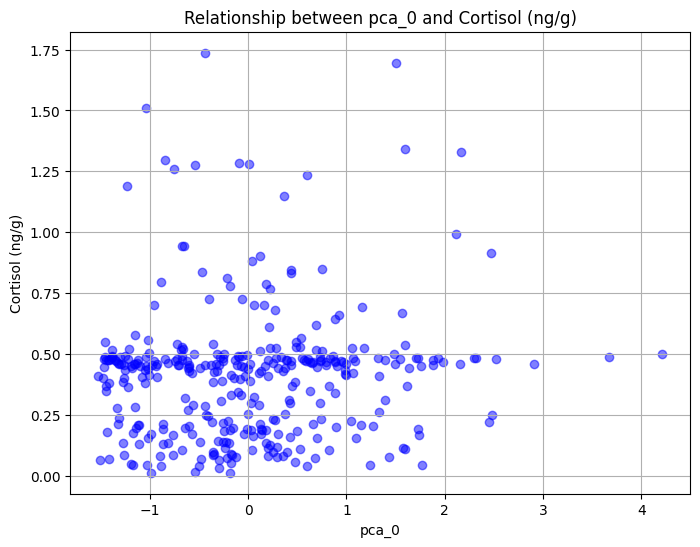

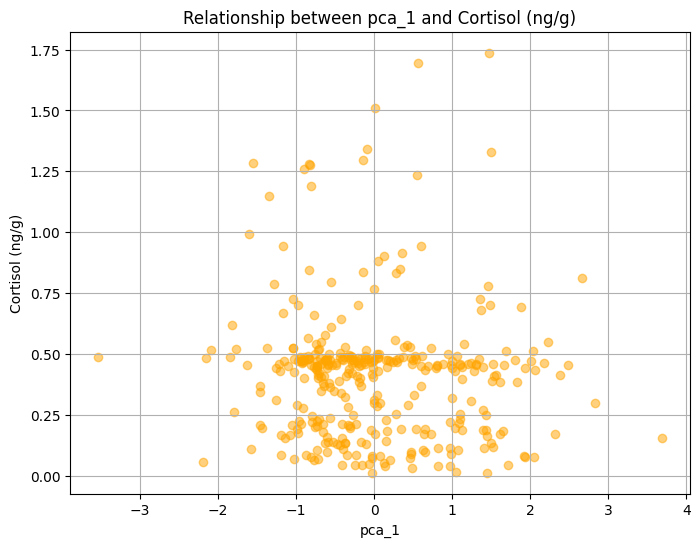

In [14]:
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

pca = PCA(n_components=0.95)

# Select the features 
PCAfeatures = df_augmented.drop(columns=['Cortisol  (ng/g)'])

# Fit and transform the features to reduce dimensions
X_pca = pca.fit_transform(PCAfeatures)

# Create a DataFrame from the PCA results
df_augmented_pca = pd.DataFrame(X_pca, columns=[f'pca_{i}' for i in range(X_pca.shape[1])])

# Concatenate the target column with the new PCA features DataFrame
df_augmented_pca = pd.concat([df_augmented[['Cortisol  (ng/g)']], df_augmented_pca], axis=1)

# Print a preview of the PCA augmented DataFrame
print(df_augmented_pca.head())

# Print dimensions of the new DataFrame
print("Dimensions of the new DataFrame:", df_augmented_pca.shape)

# Rescale df_augmented_pca
features_pca = df_augmented_pca.drop(columns=['Cortisol  (ng/g)'])
scaled_features_pca = scaler.fit_transform(features_pca)

# Create a DataFrame for the scaled features
df_pca_scaled = pd.DataFrame(scaled_features_pca, columns=features_pca.columns)

# Add the target variable 'Income_Med' back to the scaled DataFrame
df_pca_scaled = pd.concat([df_augmented_pca[['Cortisol  (ng/g)']].reset_index(drop=True), df_pca_scaled], axis=1)

# Scatter plot for pca_0 vs Cortisol (ng/g)
plt.figure(figsize=(8, 6))
plt.scatter(df_pca_scaled['pca_0'], df_pca_scaled['Cortisol  (ng/g)'], color='blue', alpha=0.5)
plt.title('Relationship between pca_0 and Cortisol (ng/g)')
plt.xlabel('pca_0')
plt.ylabel('Cortisol (ng/g)')
plt.grid(True)
plt.show()

# Scatter plot for pca_1 vs Cortisol (ng/g)
plt.figure(figsize=(8, 6))
plt.scatter(df_pca_scaled['pca_1'], df_pca_scaled['Cortisol  (ng/g)'], color='orange', alpha=0.5)
plt.title('Relationship between pca_1 and Cortisol (ng/g)')
plt.xlabel('pca_1')
plt.ylabel('Cortisol (ng/g)')
plt.grid(True)
plt.show()



**Linear Model**

Running a basic linear model to have a RMSE to compare other models to

In [15]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = df_pca_scaled.drop(columns=['Cortisol  (ng/g)'])  
y = df_pca_scaled['Cortisol  (ng/g)'] 

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2010) 

# Linear Regression model
model = LinearRegression()

# Cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
cv_rmse_mean = -cv_scores.mean()  

# Fitting the model
model.fit(X_train, y_train)

# Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calculating RMSE
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)

print("Cross-Validation RMSE:", cv_rmse_mean)




Cross-Validation RMSE: 0.2721323848585858


**Model Exploration**

1. *Linear Regression*    

Linear regression has fast training times and creates coefficients to rank of predictor-target relationships and is considered easy to interpert. However, its assumption of linear relationships makes it sensitive to outliers and multicollinearity. Additionally, it relies on assumptions like independence of errors and normally distributed errors, which must be met for accurate results.

2. *Polynomial Regression*

Polynomial regression fits a polynomial function to the data, allowing for non-linear relationships. This makes them good for various data patterns, although it assumes a polynomial relationship between dependent and independent variables and can be prone to over fitting

3. *Stochastic Gradient Descent (SGD)*

It updates the model parameters iteratively using a small random subset of the training data. Better for avoiding overfitting in larger datasets. Requires pre-processing such as scaling for optimal results. Particuarlly useful with large datasets due to it being computationally efficient. 

4. *Ridge Regression*

Ridge regression is a regularized version of linear regression that adds a penalty term to the ordinary least squares objective function, preventing overfitting by shrinking the coefficients towards zero. Ridge regression handles multicollinearity well and reduces overfitting. As its a version of linear regression it assumes a linear relationship between variables.

5. *Decision Trees*

Advantages of decision trees include ability to capture nonlinear relationships, and handling of both numerical and categorical features without requiring data transformation. They also handle outliers and missing values okay. Although, decision trees areprone to overfitting, especially with deep trees and can create biased trees. Additionally they are considered more complex to interpert when compared to a linear model.
   
6. *Random Forest*

Can captures non-linear relationships and can handle outliers and missing values. Less prone to overfitting when compared to descision trees. Not as easy to interpert as linear regression, but can handel categorical variables and can provide feature importance scores. 



**Model Selection**

As this data doesn't have strong linear relationships, I will be choosing models that are able to capture non-linear relationships

1. Decision Trees
2. Random Forest
3. Polynomial Regression

**Decision Tree with Grid Search**

First, a default Decision Tree model was trained to establish a baseline performance. Then, a Grid Search was performed to identify the best hyperparameters for the Decision Tree model. These optimal hyperparameters were subsequently used to train a new model. Finally, the performance of the new model was evaluated and compared to that of the default model to assess improvement.

The inital default model produced a RMSE of  0.3947
Lowest RMSE by grid search: 0.2660
The model with hyperparameters produced a RMSE of  0.2701

This significant reduction in RMSE indicates that the grid search successfully identified hyperparameters that substantially improved the model's performance.

Comparing the refined decision tree model to the default linear model with an RMSE of 0.721 reveals that the refined decision tree model outperformed the linear model significantly. Although the default decison tree model performed slightly worse than the default linear model.This observation contrasts with the expectation that decision tree models, which do not assume a linear relationship between the independent and dependent variables, would outperform the linear regression model

Overall these findings underscore the importance of hyperparameter tuning in optiziming models performance. 

In [16]:
from sklearn.tree import DecisionTreeRegressor # This is our learning algorithm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Separate target and predictors into separate objects
X = df_pca_scaled.drop(columns=['Cortisol  (ng/g)'])  
y = df_pca_scaled['Cortisol  (ng/g)']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2010)

# train deafult model before grid search
default_DT_model = DecisionTreeRegressor(random_state=2010)
default_DT_model.fit(X_train, y_train)
y_pred = default_DT_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
default_DT_rmse = np.sqrt(mse)
print("Default Decision Tree (RMSE):", default_DT_rmse)

# Define the grid of parameters to search and run grid search
param_grid = {
    'max_depth': range(1, 28),
    'min_samples_split': range(2, 28),
    'min_samples_leaf': range(1, 28),
    'max_features': ['sqrt', 'log2'] + list(range(1, X.shape[1] + 1))
}
model = DecisionTreeRegressor(random_state=2010)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and RMSE
best_params = grid_search.best_params_
best_rmse = -grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Lowest RMSE:", best_rmse)

# Re-run model with tuned hyperparameteres 
best_DT_model = DecisionTreeRegressor(max_depth=2, min_samples_split=2, min_samples_leaf=16, max_features= 'sqrt', random_state=2010)
cv_scores = cross_val_score(best_DT_model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
best_DT_mean_rmse = -np.mean(cv_scores)

print("Root Mean Squared Error (Using Best Hyperparameters with Cross-Validation):", best_DT_mean_rmse)

DecisionTree=best_DT_mean_rmse


Default Decision Tree (RMSE): 0.3947789396502386
Best Hyperparameters: {'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 16, 'min_samples_split': 2}
Lowest RMSE: 0.26601597520565035
Root Mean Squared Error (Using Best Hyperparameters with Cross-Validation): 0.26601597520565035


**Random Forest with Random Search** 

A random forest model was used with a Random Search method to find the best combination of hyperparameters. After evaluating 1250 different combinations of hyperparameters, the best configuration was identified. 

The defualt RMSE: 0.2950
Lowest RMSE from random search: 0.2802
The refined model RMSE:0.2790

 The optimal hyperparameter values include 800 trees, a minimum samples split of 10, a minimum samples leaf of 4, a maximum depth of 10, and bootstrap sampling set to True. 

These findings show a slight improvement from the default to the refined model RMSE.

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Splitting the data into training and testing sets
X = df_pca_scaled.drop(columns=['Cortisol  (ng/g)'])  
y = df_pca_scaled['Cortisol  (ng/g)']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2010)

# Run model default
default_RF_model = RandomForestRegressor(random_state=2010)
cv_scores = cross_val_score(default_RF_model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
default_RF_mean_rmse = -np.mean(cv_scores)

print('Default Random Forest:', default_RF_mean_rmse)

# Random Search
pipeline = Pipeline([
    ('rf', RandomForestRegressor(random_state=2010))
])

param_distributions = {
    'rf__n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)],  # How many trees should be trained?
    'rf__max_depth': [int(x) for x in np.linspace(10, 110, num=11)],  # Maximum number of levels in each tree
    'rf__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'rf__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at each leaf node
    'rf__bootstrap': [True, False]  # Method of selecting samples for training each tree
}

random_search = RandomizedSearchCV(pipeline, param_distributions, n_iter=250, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1, random_state=2010)
random_search.fit(X_train, y_train)

best_estimator = random_search.best_estimator_
best_params = random_search.best_params_

predictions = best_estimator.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print("Lowest overall RMSE achieved with Random Forest:", rmse)
print("Corresponding hyperparameter values:")
for param, value in best_params.items():
    print(param, ":", value)


# Run model with tuned hyperparameters
best_RF_model = RandomForestRegressor(n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_depth=10, bootstrap=True, random_state=2010)
cv_scores = cross_val_score(best_RF_model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
best_RF_mean_rmse = -np.mean(cv_scores)

RandomForest = best_RF_mean_rmse
print("Best RMSE with tuned hyperparameters:", best_RF_mean_rmse)


Default Random Forest: 0.2950513969872005
Fitting 5 folds for each of 250 candidates, totalling 1250 fits
Lowest overall RMSE achieved with Random Forest: 0.2802885359673075
Corresponding hyperparameter values:
rf__n_estimators : 800
rf__min_samples_split : 10
rf__min_samples_leaf : 4
rf__max_depth : 10
rf__bootstrap : True
Best RMSE with tuned hyperparameters: 0.27764948796388983


**Polynomial Regression**

A grid search was conducted to determine the most suitable degree of polynomial for polynomial regression, aiming to capture potential non-linear relationships in the data. 

Surprisingly, the search revealed that a polynomial of degree 1, equivalent to a linear model, yielded the lowest Root Mean Square Error (RMSE). This result was unexpected, especially considering that a linear model typically assumes a simple linear relationship between variables which this data doesn't show. Notably, the polynomial model with a degree of 1 outperformed the default linear model, which had an RMSE of 0.3163 (prior to cross-validation or hyperparameter tuning). This suggests that despite the simplicity of a linear relationship, the polynomial regression model with a degree of 1 was more effective in capturing the underlying patterns in the data than higher degrees. 

In [18]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


X = df_pca_scaled.drop(columns=['Cortisol  (ng/g)'])  
y = df_pca_scaled['Cortisol  (ng/g)']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2010)


# Initialize default Polynomial Regression model with degree of 2
degree = 2 
polynomial_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

cv_scores = cross_val_score(polynomial_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

rmse_scores = np.sqrt(-cv_scores)

default_Poly_rmse = np.mean(rmse_scores)
print("Mean Root Mean Squared Error (Polynomial Regression with 5-fold CV):", default_Poly_rmse)


# Define the polynomial degree parameters to search
param_grid = {
    'poly__degree': range(1, 15)  
}

# Define the polynomial regression pipeline
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),  
    ('reg', LinearRegression()) 
])

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and RMSE
best_params = grid_search.best_params_
best_rmse = -grid_search.best_score_

print("Best Polynomial Degree:", best_params['poly__degree'])
print("Lowest RMSE:", best_rmse)


# Initialize hyperparameter Polynomial Regression model
degree = 1  
polynomial_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

cv_scores = cross_val_score(polynomial_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

rmse_scores = np.sqrt(-cv_scores)

mean_Poly_rmse = np.mean(rmse_scores)
print("Mean Root Mean Squared Error (Polynomial Regression with 5-fold CV):", mean_Poly_rmse)

PolynomialRegression=mean_Poly_rmse



Mean Root Mean Squared Error (Polynomial Regression with 5-fold CV): 0.27362128752267534
Best Polynomial Degree: 1
Lowest RMSE: 0.2721323848585858
Mean Root Mean Squared Error (Polynomial Regression with 5-fold CV): 0.2721323848585858


**Model Comparison and Discussion**

The model that performed the best was the Random Forest model. It's reasonable to expect a Random Forest model to outperform a single Decision Tree due to Random forest being repeated decison trees, which mitigates overfitting and enhances generalization. By constructing multiple trees on different subsets of the data and aggregating their predictions, random forests offers increased stability and reduced sensitivity to small variations in the training data. Therefore, I am not surpised that the random forest model performed better thant he decison tree model.

Moreover, the random forest out perfomed the polynomial model. In this case the grid search concluded that the best polynomial degree for this dataset was 1. Which means it is a linear model. Therefore, I expected the random forest models to outperfom the linear model also becuase the relationship between the target and predictos was complex and not obviously linear. Tree type models are better at handeling non-linear relationships, outliers and noise in the data than a linear model. 

Although, the linear model performed better than the decision tree model, which performed the wrost. Decision trees are capable of capturing nonlinear relationships, making them suitable for a wide range of datasets. However, linear models, by design, assume a linear relationship between features and target variables, which may not accurately represent the underlying data structure. In this case, upon initial examination of the first set of scatterplots, the predictors did not exhibit clear linear relationships with Cortisol, although it also did not demonstrate entirely nonlinear patterns. I initially concluded the relationship between predictors and cortisol were non-linear, atlthough after assessing the scatter plots of the two principal components a slight linear relationship became more obvious and therefore I am not interly surprised that the linear model out performed the decison tree. 

While the linear model ultimately outperformed the decision tree model but not the Random Forest model, it's good to consider the interpretability aspect. Linear models offer straightforward interpretability. Despite the capability of Tree type models to capture nonlinear relationships, their interpretability can be more complex. Therefore, depending on the project, the choice between linear and tree-based models should also consider the trade-off between predictive performance and interpretability.

In addition to the performance comparison between the models, it's worth noting that tuning hyperparameters via grid search or random search improved the models performance across all model types. While modest improvements were seen in both the linear and random forest models, the most significant enhancement was seen in the decision tree model. This observation underscores the importance of hyperparameter optimization in maximizing model performance and highlights the flexibility of these techniques in fine-tuning the models to better fit the underlying data.

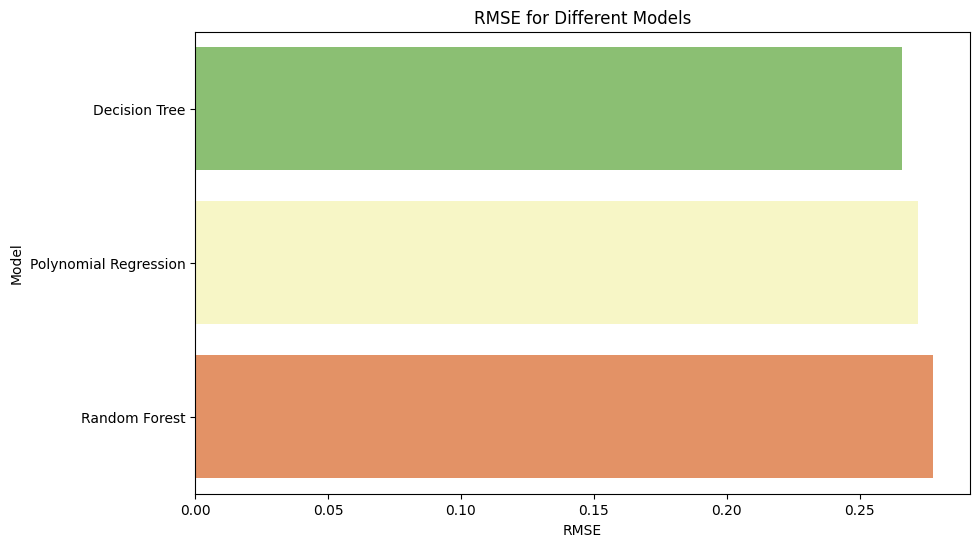

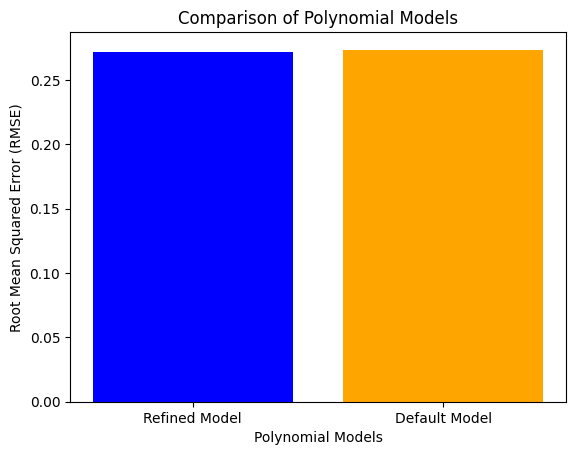

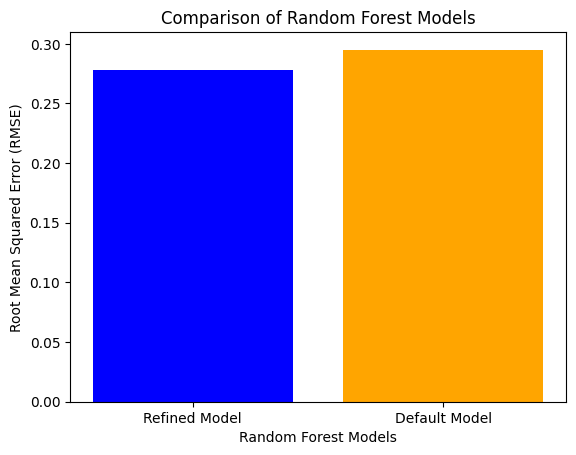

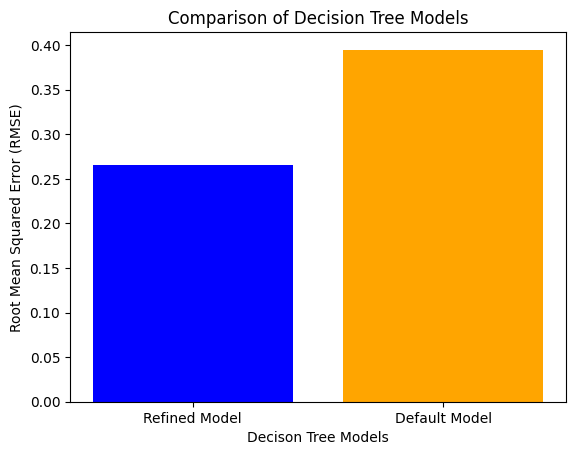

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a dictionary with the model names as keys and RMSE values as values
data = {
    'Model': ['Decision Tree', 'Random Forest', 'Polynomial Regression'],
    'RMSE': [DecisionTree, RandomForest, PolynomialRegression ]
}
# Create the DataFrame
df_comp = pd.DataFrame(data)

df_comp_sorted = df_comp.sort_values(by='RMSE', ascending=True)
palette = sns.color_palette("RdYlGn_r", len(df_comp_sorted))

plt.figure(figsize=(10, 6))
sns.barplot(x='RMSE', y='Model', data=df_comp_sorted, hue='Model', legend=False, palette=palette)

plt.xlabel('RMSE')
plt.ylabel('Model')
plt.title('RMSE for Different Models')
plt.show()


# Bar graph for polynomial comparison
plt.bar(['Refined Model', 'Default Model'], [PolynomialRegression, default_Poly_rmse], color=['blue', 'orange'])
plt.title('Comparison of Polynomial Models')
plt.xlabel('Polynomial Models')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.show()

# Bar graph for Random Forest comparison
plt.bar(['Refined Model', 'Default Model'], [RandomForest, default_RF_mean_rmse], color=['blue', 'orange'])
plt.title('Comparison of Random Forest Models')
plt.xlabel('Random Forest Models')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.show()

# Bar graph for Decison Tree comparison
plt.bar(['Refined Model', 'Default Model'], [DecisionTree, default_DT_rmse], color=['blue', 'orange'])
plt.title('Comparison of Decision Tree Models')
plt.xlabel('Decison Tree Models')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.show()

